# Pat Nyem Ake' - PNA

Import everything needed

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

## Unzip dataset
Please find the ``dataset_zipped.zip`` in ``workspace/external_files``. This zip file is simply the training, validation, and test datasets zipped for convenience. Upload the file into this Colab runtime.

In [ ]:
!cd /content/ && unzip dataset_zipped.zip

## Import training and validation datasets

In [4]:
training_path = '/content/dataset/training/' # Training path
pathlist = os.listdir(training_path) # Training path list
print(len(pathlist)) # There should be 62 reservoirs in training

62


In [ ]:
display(pathlist)

In [6]:
dflist_training_inputs = [pd.read_csv(training_path + path + '/state.csv') for path in pathlist]
dflist_training_outputs = [pd.read_csv(training_path + path + '/production.csv') for path in pathlist]

In [7]:
df_inputs_list = [reservoir for reservoir in dflist_training_inputs] # Create list of dataframes for each reservoir's state.csv
df_outputs_list = [reservoir for reservoir in dflist_training_outputs] # Create list of dataframes for each reservoir's production.csv

In [8]:
validation_path = '/content/dataset/validation/' # Validation path
pathlist_to_validation = os.listdir('/content/dataset/validation/') # Validation path list
print(len(pathlist_to_validation)) # There should be 26 reservoirs in validation

26


In [ ]:
display(pathlist_to_validation)

In [10]:
dflist_validation_inputs = [pd.read_csv(validation_path + path + '/state.csv') for path in pathlist_to_validation]
dflist_validation_outputs = [pd.read_csv(validation_path + path + '/production.csv') for path in pathlist_to_validation]

In [11]:
df_inputs_list_validation = [reservoir for reservoir in dflist_validation_inputs] # Create list of dataframes for each reservoir's state.csv
df_outputs_list_validation = [reservoir for reservoir in dflist_validation_outputs] # Create list of dataframes for each reservoir's production.csv

Turn date information into index (the date column will not be FP into the NN, but only serve as an index).

In [12]:
# Training production.csv dataset - index by date
for reservoir in range(len(df_outputs_list)):
  df_outputs_list[reservoir]['Date'] = pd.to_datetime(df_outputs_list[reservoir]['Date'])
  df_outputs_list[reservoir].set_index('Date', inplace=True)

# Validation production.csv dataset - index by date
for reservoir in range(len(df_outputs_list_validation)):
  df_outputs_list_validation[reservoir]['Date'] = pd.to_datetime(df_outputs_list_validation[reservoir]['Date'])
  df_outputs_list_validation[reservoir].set_index('Date', inplace=True)

Vertically stack and reshape spatial data (state.csv)

In [13]:
df_spatial = (np.vstack(dflist_training_inputs)).reshape(62, 5183, 8) # vstack and reshape spatial training dataset
df_spatial_validation = (np.vstack(dflist_validation_inputs)).reshape(26, 5183, 8) # vstack and reshape spatial validation dataset

Cull the temporal data - _Cull_ here means to make the dimensions of the temporal dataset homogenous. Since the no. of rows of each reservoir's production.csv is inconsistent, we need to find the minimum no. of rows, and _cull_ all the others with more than the minimum.

In [14]:
# This block finds the minimum number of production.csv rows. It should be 260.
dummy = []
for i in range(len(df_outputs_list)):
  dummy.append(df_outputs_list[i].shape[0])
print(min(dummy))

260


### Cull temporal data

In [15]:
# Cull the training temporal dataset
culled_outputs_list = []
for i in range(len(df_outputs_list)):
  culled_outputs_list.append(df_outputs_list[i][:260])

# Cull the validation temporal dataset
culled_outputs_list_validation = []
for i in range(len(df_outputs_list_validation)):
  culled_outputs_list_validation.append(df_outputs_list_validation[i][:260])

Reshape the culled datasets

In [16]:
df_temporal_culled = np.vstack(culled_outputs_list).reshape(62, 260, 3)
df_temporal_culled_validation = np.vstack(culled_outputs_list_validation).reshape(26, 260, 3)

# Dataset normalization

Normalize the datasets. This is another technical problem: the scaler expects max ndim=3. We can circumvent this by first reshaping the tensors, normalize, and then invert the reshape.

**NOTE:** The copy() method is used to prevent hidden control flows from causing funky errors.

In [17]:
train_scaler_X = MinMaxScaler()
train_scaler_Y = MinMaxScaler()

normalized_Y = train_scaler_Y.fit_transform(df_temporal_culled.reshape(62*260, 3))
normalized_X = train_scaler_X.fit_transform(df_spatial.reshape(62*5183, 8))

normalized_Y = normalized_Y.copy().reshape(62, 260, 3)
normalized_X = normalized_X.copy().reshape(62, 5183, 8)

In [18]:
valid_scaler_X = MinMaxScaler()
valid_scaler_Y = MinMaxScaler()

normalized_Y_valid = valid_scaler_Y.fit_transform(df_temporal_culled_validation.reshape(26*260, 3))
normalized_X_valid = valid_scaler_X.fit_transform(df_spatial_validation.reshape(26*5183, 8))

normalized_Y_valid = normalized_Y_valid.copy().reshape(26, 260, 3)
normalized_X_valid = normalized_X_valid.copy().reshape(26, 5183, 8)

In [19]:
X_train = normalized_X
y_train = normalized_Y

X_valid = normalized_X_valid
Y_valid = normalized_Y_valid

# Define architecture

In [61]:
model = Sequential()

# Example LSTM layer
model.add(LSTM(256, input_shape=(5183, 8), return_sequences=True))

# Global Average Pooling to reduce dimensionality
model.add(GlobalAveragePooling1D())

# Dense layers to adjust output
model.add(Dense(256, activation='relu'))
model.add(Dense(260*3))  # Output dimension (260 sequences, 3 features each)

# Reshape output to desired shape (260, 3)
model.add(Reshape((260, 3)))
model.add(LSTM(100, return_sequences = True))
model.add(LSTM(100, return_sequences = True))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(3, activation = 'relu', ))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')  # Use appropriate loss for your task

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 5183, 256)           │         271,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 780)                 │         200,460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 260, 3)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 260, 100)            │          41,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 260, 100)            │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 260, 8)              │             808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 260, 3)              │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 660,447 (2.52 MB)

 Trainable params: 660,447 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

## Define custom loss

This is a custom loss that takes into account the relatively large weight Cumulative Gas Production and Cumulative Oil Production has over Cumulative Water Production. These hyperparameters were chosen over trial and error. The following is a closed-form expression of our loss function:

$\text{Modified loss} = \text{MSE}(Y_{\text{true}, i}, Y_{\text{pred}, i}) - \kappa(a\phi(\text{Gas}) + b\phi(\text{Oil}) + c\phi(\text{Water})) $

where $\kappa=0.001$ is the penalty factor, $\sqrt{a^2 + b^2 + c^2}\approx 0.7$, $\text{ chosen } \{a=0.1, b=0.25, c=0.6 \ | \ a<b<c\}$

and $\phi$ is a monotonicity penalty function defined:

$
\phi(\text{feature})=
    \begin{cases}
        Y^{\text{feature}}_{\text{pred}, i} - Y^{\text{feature}}_{\text{pred}, i+1} & \text{if } Y^{\text{feature}}_{\text{pred}, i} - Y^{\text{feature}}_{\text{pred}, i+1} < 0 \\
        0 & \text{otherwise}
    \end{cases}
$

and $\text{feature} = \text{Gas}, \text{Oil}, \text{Water}$

Note that the $0.7$ Euclidean norm is a heuristic determined from trial and error.

In [21]:
penalty_factor = 0.001

In [60]:
def modified_mse(y_true, y_pred):
    """Custom loss function that adds a penalty if the previous prediction is greater than the current prediction.

    Args:
        y_true: The true labels.
        y_pred: The predicted labels.

    Returns:
        The loss value.
    """

    # Calculate the difference between current and previous predictions
    diff_1 = y_pred[:, 1:, 0:1] - y_pred[:, :-1, 0:1] # Gas feature
    diff_2 = y_pred[:, 1:, 1:2] - y_pred[:, :-1, 1:2] # Oil feature
    diff_3 = y_pred[:, 1:, 2:3] - y_pred[:, :-1, 2:3] # Water feature

    mask_1 = tf.where(diff_1 > 0, 0.0, diff_1)
    mask_2 = tf.where(diff_2 > 0, 0.0, diff_2)
    mask_3 = tf.where(diff_3 > 0, 0.0, diff_3)


    # Calculate the penalty based on the mask and a penalty factor
    penalty_1 = -0.1 * penalty_factor * mask_1
    penalty_2 = -0.25 * penalty_factor * mask_2
    penalty_3 = -0.60 * penalty_factor * mask_3

    # Calculate the mean squared error (MSE) loss
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred) # Use MSE as a function

    # Combine the MSE and penalty
    loss = mse + tf.reduce_sum(penalty_1) + tf.reduce_sum(penalty_2) + tf.reduce_sum(penalty_3) # Ensure penalty is a scalar

    return loss

## Train the model

In [62]:
model.compile(optimizer='adam', loss=modified_mse)
history = model.fit(X_train, y_train, validation_data=(X_valid, Y_valid), epochs=75, verbose=1)

Epoch 1/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 682ms/step - loss: 0.2507 - val_loss: 0.2128
Epoch 2/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step - loss: 0.2122 - val_loss: 0.1465
Epoch 3/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step - loss: 0.1342 - val_loss: 0.0405
Epoch 4/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step - loss: 0.1092 - val_loss: 0.0468
Epoch 5/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step - loss: 0.0408 - val_loss: 0.0486
Epoch 6/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step - loss: 0.0549 - val_loss: 0.0683
Epoch 7/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step - loss: 0.0704 - val_loss: 0.0695
Epoch 8/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step - loss: 0.0696 - val_loss: 0.0598
Epoch 9/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step - loss: 0.0599 - val_loss: 0.0450
Epoch 10/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step - loss: 0.0432 - val_loss: 0.0313
Epoch 11/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 405ms/step - loss: 0.0297 - val_loss: 0.0243
Epoch 12/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - loss: 0.0214 - val_lo

Save the model to a file. Please download **immediately** as Colab will not store the file.

In [100]:
model.save('PNA_model.keras')

Load previous model (this is for experimentation purposes, or if you don't want to train from scratch). Please make sure the block defining the ```modified_mse``` class has been run.

In [ ]:
model = load_model('/content/PNA_model.keras', custom_objects={'modified_mse': modified_mse})

## Plot training loss and validation loss

This is to look for signs of under/overfitting. Note that the losses here are calculated based on the modified loss, instead of conventional MSE.

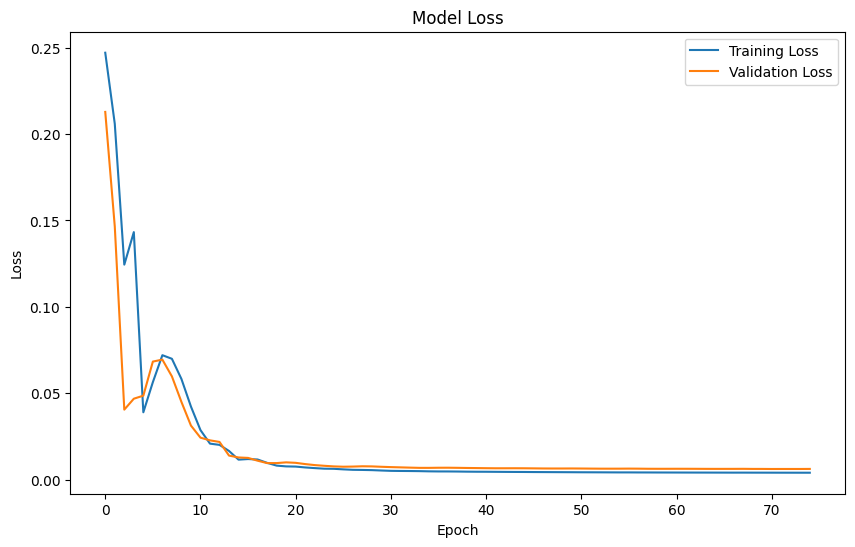

In [64]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig('train_valid_loss.png', dpi=300)
plt.show()

Export training and validation loss in a csv

In [65]:
loss_data = {
    'epoch': range(1, len(history.history['loss']) + 1),
    'training_loss': history.history['loss'],
    'validation_loss': history.history['val_loss']
}

# Convert to pandas DataFrame
df = pd.DataFrame(loss_data)

# Export the DataFrame to a CSV file
df.to_csv('training_validation_loss.csv', index=False)

# Run inference
Infer based on training inputs and validation inputs.

In [67]:
# Make predictions
train_predictions = model.predict(X_train)
validation_predictions = model.predict(X_valid)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


In [68]:
display(validation_predictions.shape)

(26, 260, 3)

## Some plots

Denormalize predictions

In [69]:
# Inverse transform the predictions
train_predictions_denorm = train_scaler_Y.inverse_transform(train_predictions.reshape(62*260, 3))
train_predictions = train_predictions_denorm.copy().reshape(62, 260, 3) # Reshape back to original shape

In [70]:
validation_predictions_denorm = valid_scaler_Y.inverse_transform(validation_predictions.reshape(26*260, 3))
validation_predictions = validation_predictions_denorm.copy().reshape(26, 260, 3) # Reshape back to original shape

# Export validation predictions

Create folder to store validation results

In [29]:
!mkdir PNA_validation_results

In [71]:
filenames = pathlist_to_validation.copy()

for i in range(26):
  filename = '/content/PNA_validation_results/' + filenames[i] + '.csv'
  df_production_test = pd.DataFrame(validation_predictions[i], columns=['Gas production cumulative', 'Oil production cumulative', 'Water production cumulative'], index=df_outputs_list_validation[i][:260].index)
  df_production_test.to_csv(filename)

Zip the validation prediction csv's

In [ ]:
!zip -r PNA_validation_results.zip '/content/PNA_validation_results'

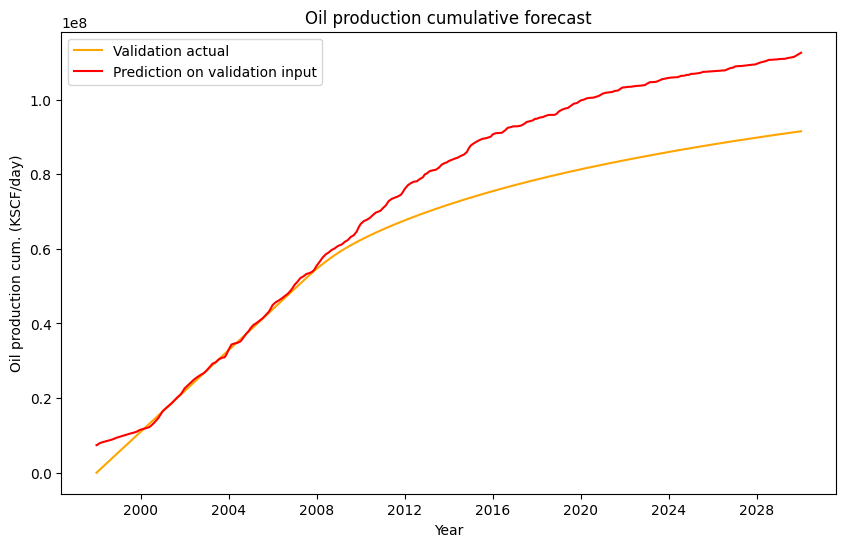

In [73]:
plt.figure(figsize=(10, 6))
reservoir = 10

plt.plot(df_outputs_list_validation[reservoir][:260].index, df_outputs_list_validation[reservoir][:260]['Oil production cumulative'], label='Validation actual', color='orange')
plt.plot(df_outputs_list_validation[reservoir][:260].index, validation_predictions[reservoir][:, 1:2], label='Prediction on validation input',color='red')

plt.title('Oil production cumulative forecast')
plt.xlabel('Year')
plt.ylabel('Oil production cum. (KSCF/day)')
plt.legend()
plt.show()

# Generate validation plots

Create a folder for validation graphs

In [48]:
!mkdir validation_graphs_oil
!mkdir validation_graphs_gas
!mkdir validation_graphs_water

Function to generate validation plots for oil production

In [74]:
def plot_all_validation_res_oil(reservoir):
  plt.figure(figsize=(10, 6))

  plt.plot(df_outputs_list_validation[reservoir][:260].index, df_outputs_list_validation[reservoir][:260]['Oil production cumulative'], label='Validation actual', color='orange')
  plt.plot(df_outputs_list_validation[reservoir][:260].index, validation_predictions[reservoir][:, 1:2], label='Prediction on validation input',color='red')

  plt.title(f'Oil production cumulative forecast - {pathlist_to_validation[reservoir]}')
  plt.xlabel('Year')
  plt.ylabel('Oil production cum. (KSCF/day)')
  plt.legend()

  filename = '/content/validation_graphs_oil/' + pathlist_to_validation[reservoir] + '.png'
  plt.savefig(filename, dpi=300)

  plt.show()

Function to generate validation plots for gas production

In [75]:
def plot_all_validation_res_gas(reservoir):
  plt.figure(figsize=(10, 6))

  plt.plot(df_outputs_list_validation[reservoir][:260].index, df_outputs_list_validation[reservoir][:260]['Gas production cumulative'], label='Validation actual', color='orange')
  plt.plot(df_outputs_list_validation[reservoir][:260].index, validation_predictions[reservoir][:, 0:1], label='Prediction on validation input',color='red')

  plt.title(f'Gas production cumulative forecast - {pathlist_to_validation[reservoir]}')
  plt.xlabel('Year')
  plt.ylabel('Gas production cum. (STB/day)')
  plt.legend()

  filename = '/content/validation_graphs_gas/' + pathlist_to_validation[reservoir] + '.png'
  plt.savefig(filename, dpi=300)

  plt.show()

Function to generate validation plots for water production

In [51]:
def plot_all_validation_res_water(reservoir):
  plt.figure(figsize=(10, 6))

  plt.plot(df_outputs_list_validation[reservoir][:260].index, df_outputs_list_validation[reservoir][:260]['Water production cumulative'], label='Validation actual', color='orange')
  plt.plot(df_outputs_list_validation[reservoir][:260].index, validation_predictions[reservoir][:, 2:3], label='Prediction on validation input',color='red')

  plt.title(f'Water production cumulative forecast - {pathlist_to_validation[reservoir]}')
  plt.xlabel('Year')
  plt.ylabel('Water production cum. (STB/day)')
  plt.legend()

  filename = '/content/validation_graphs_water/' + pathlist_to_validation[reservoir] + '.png'
  plt.savefig(filename, dpi=300)

  plt.show()

Generate plots

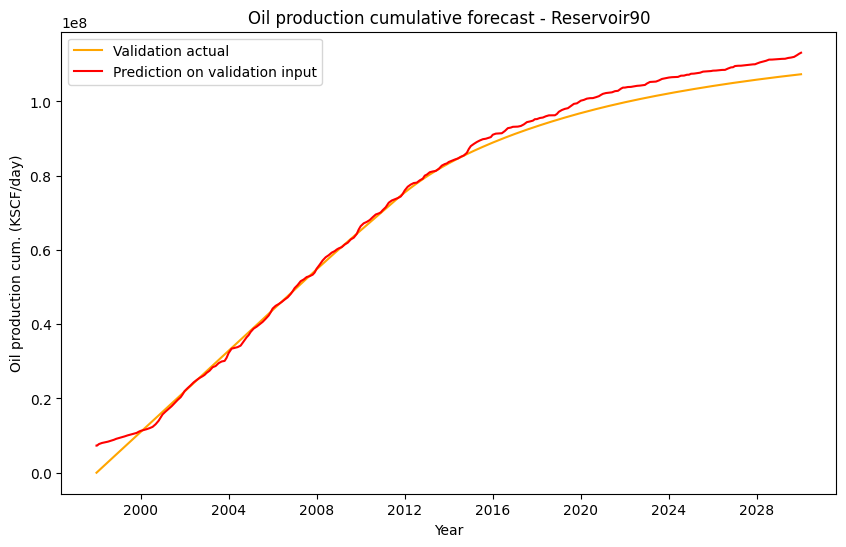

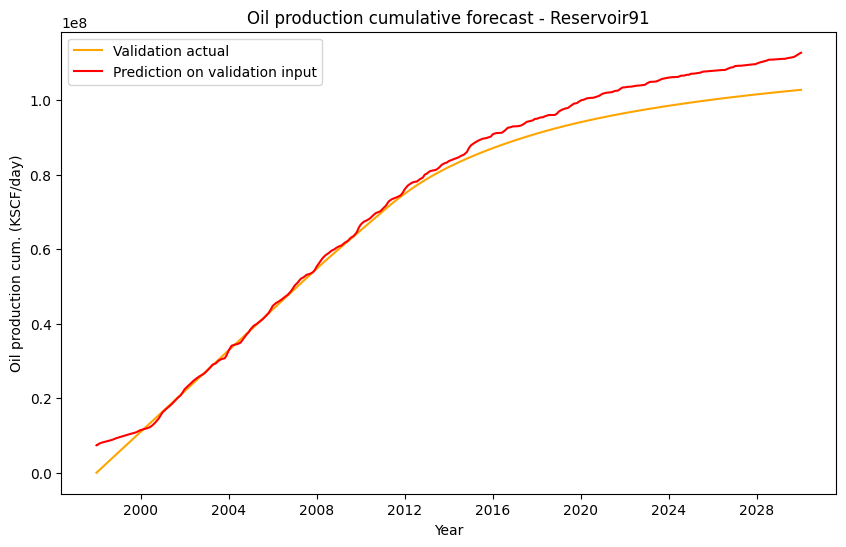

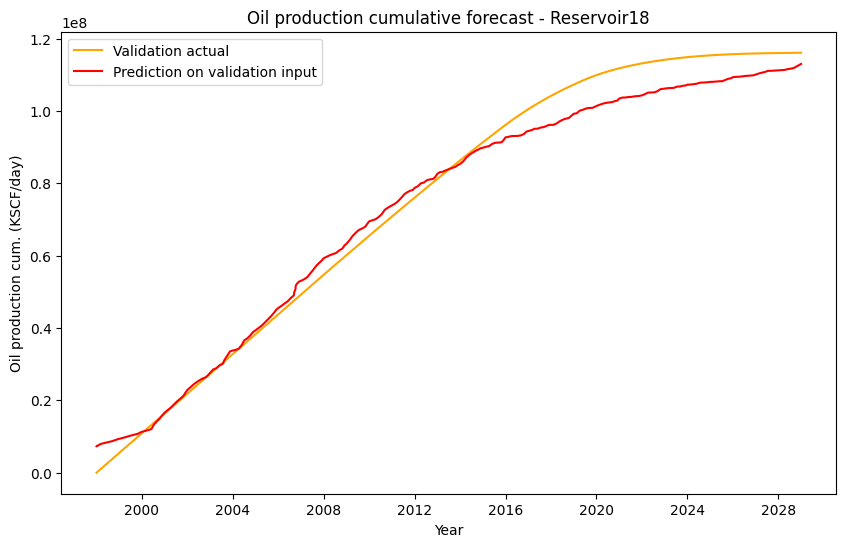

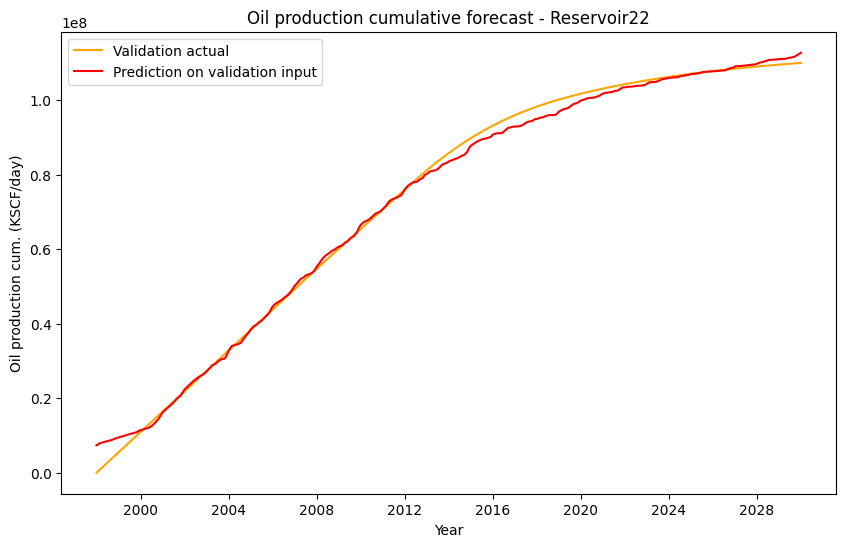

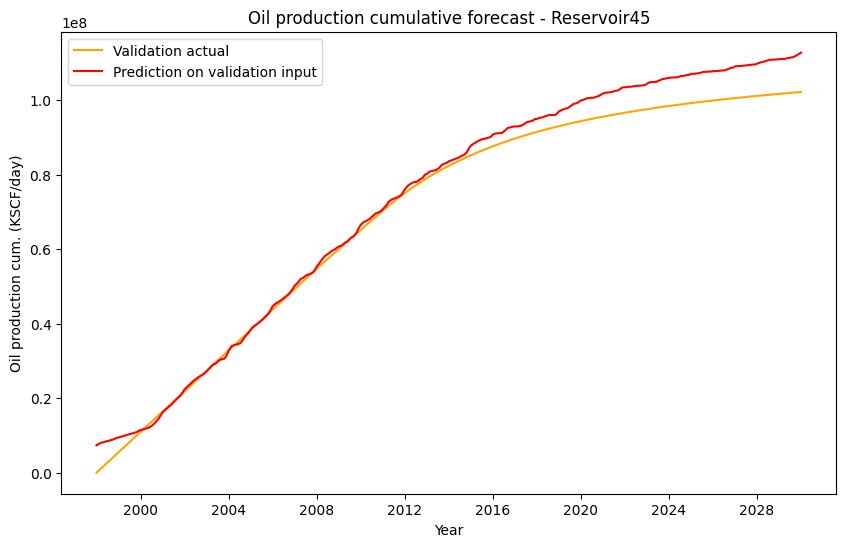

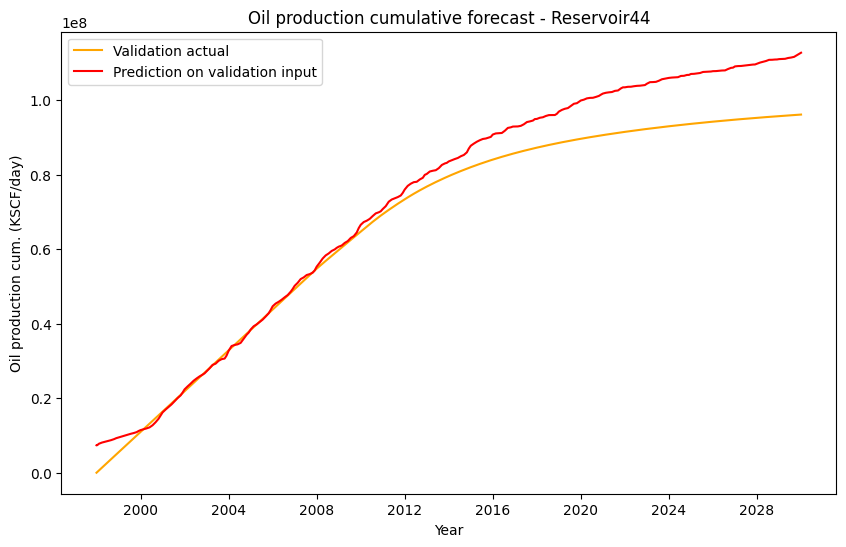

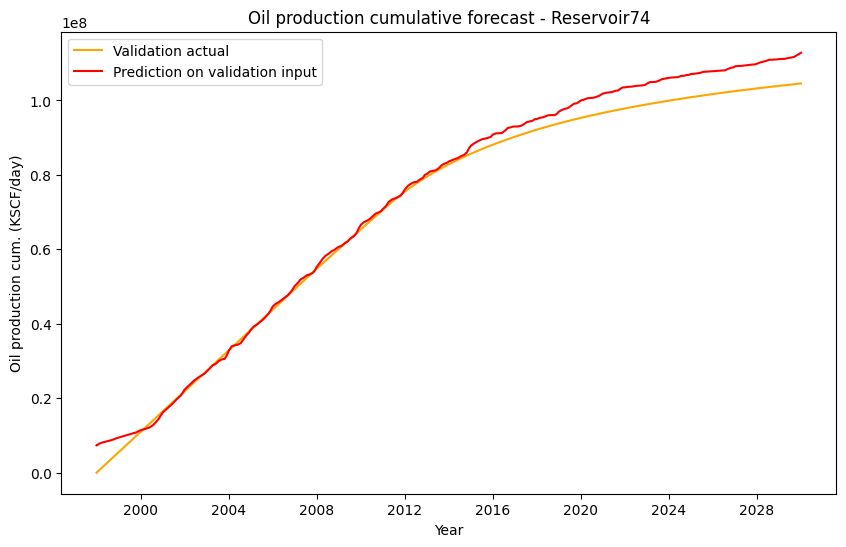

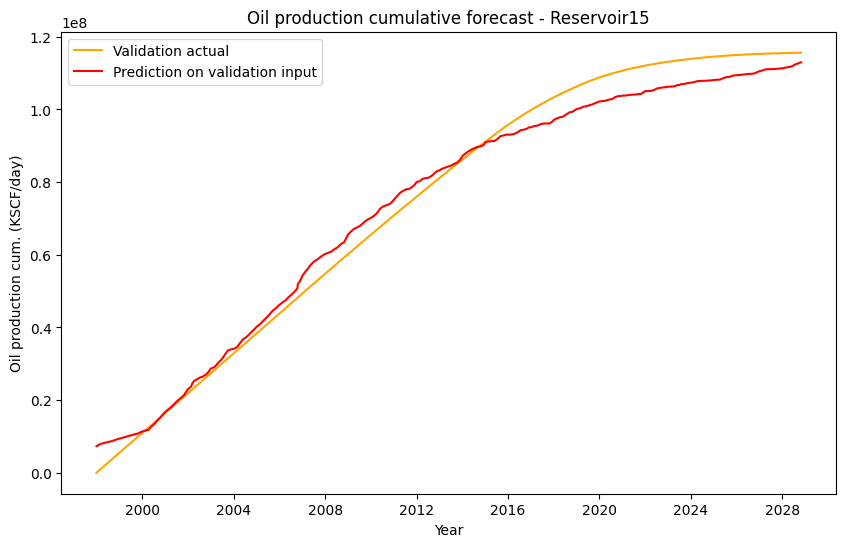

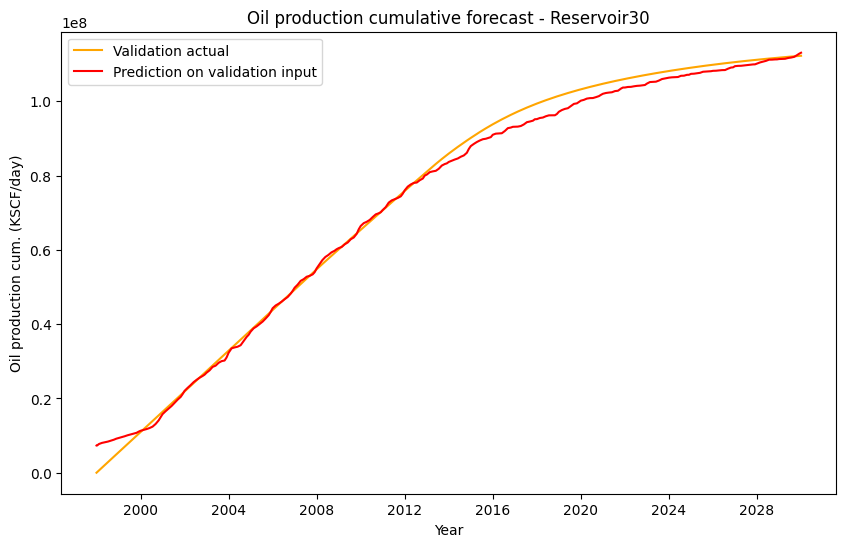

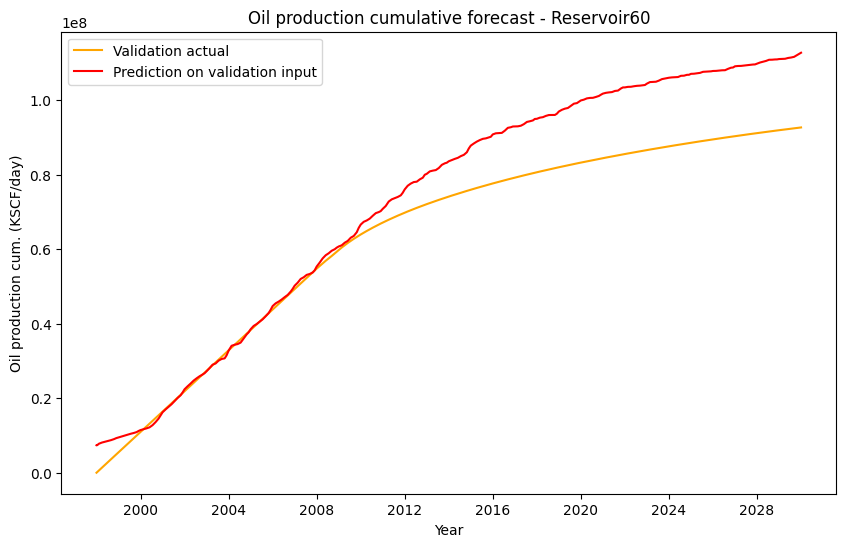

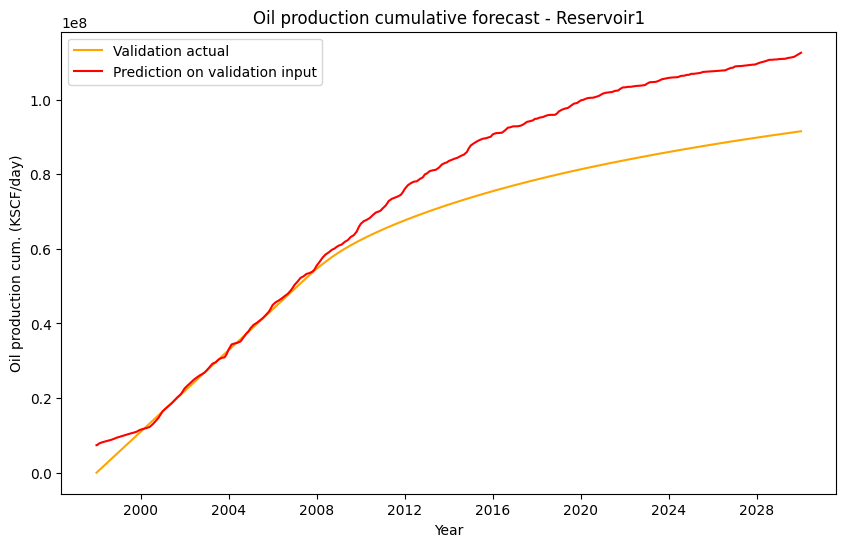

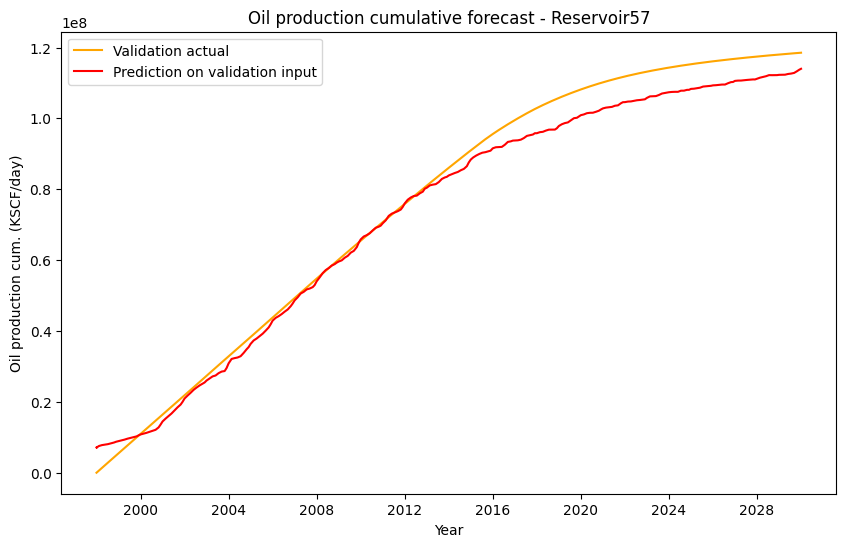

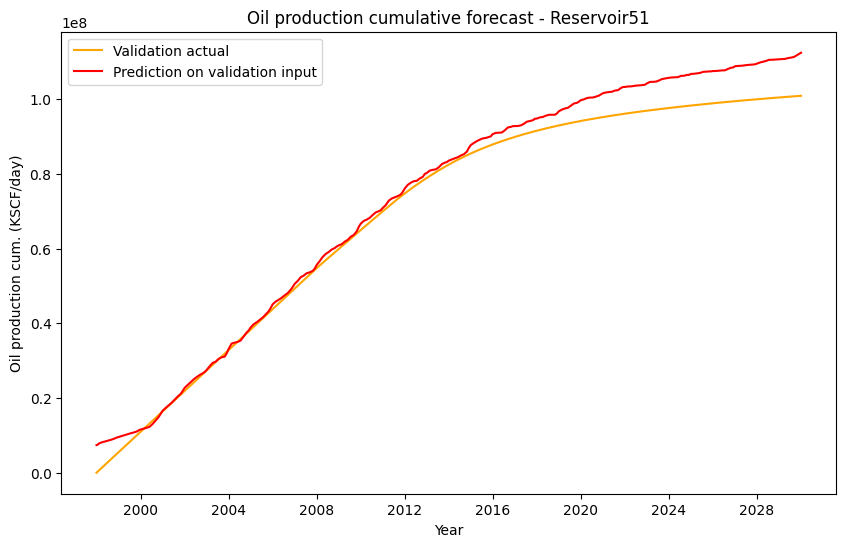

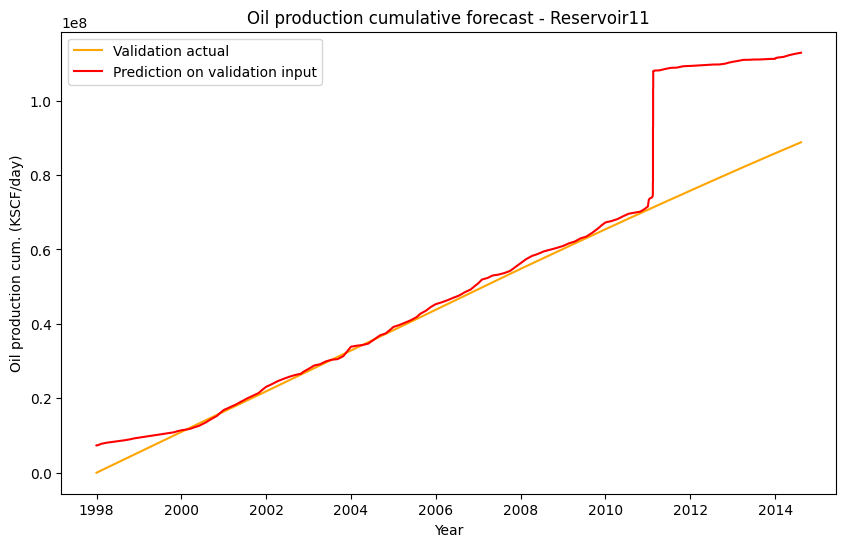

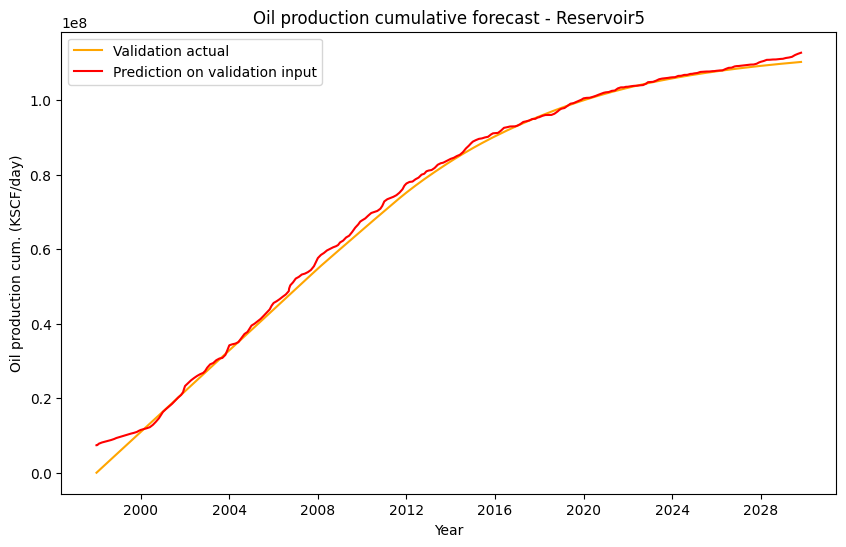

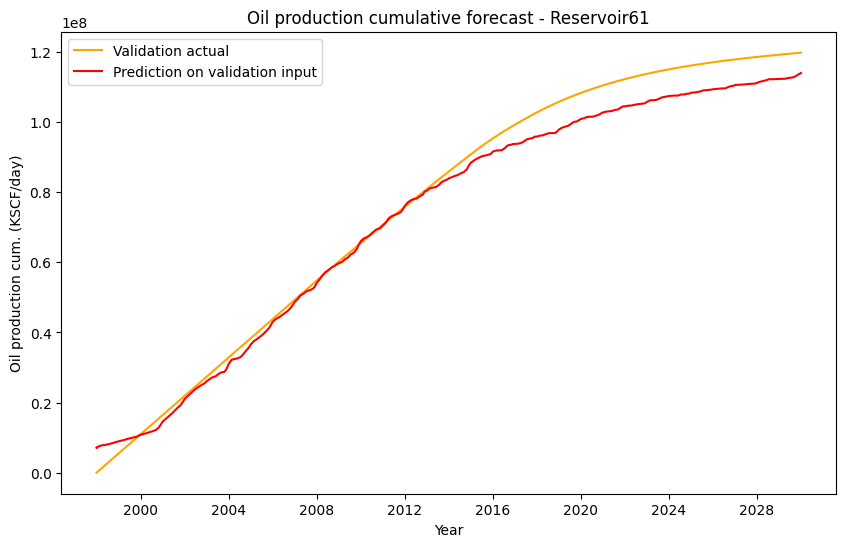

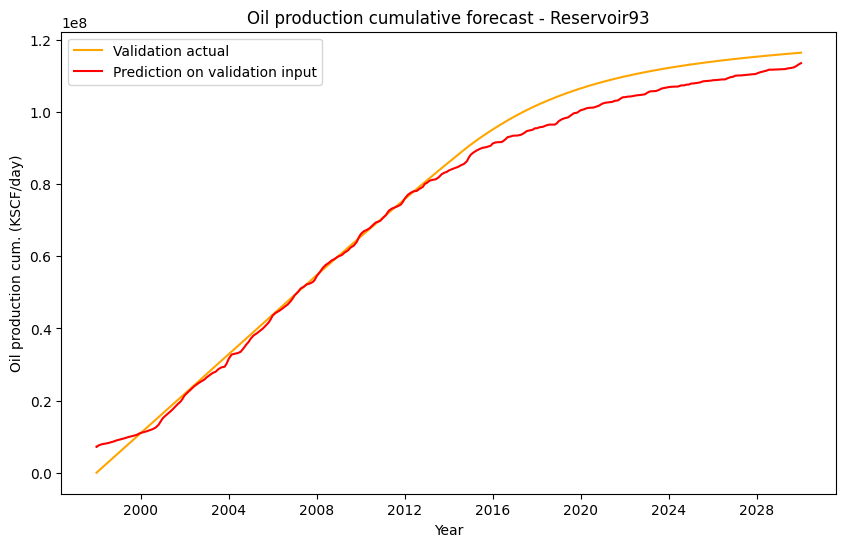

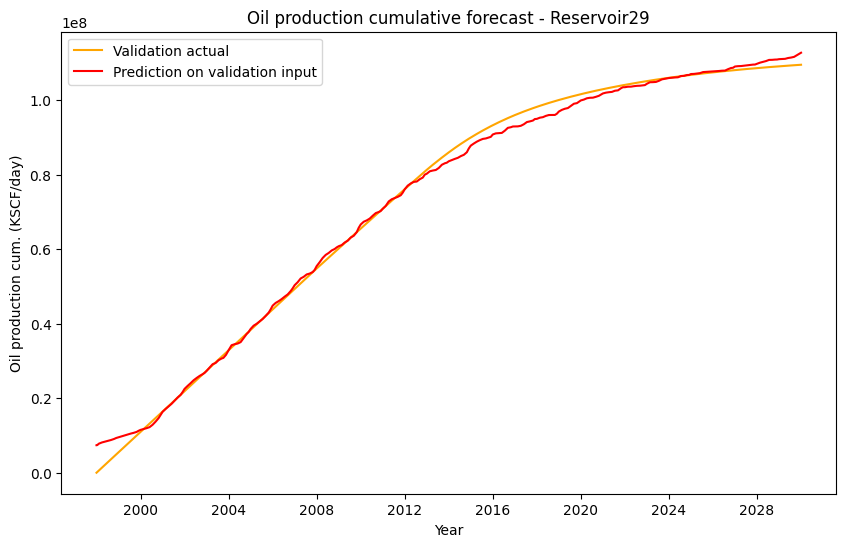

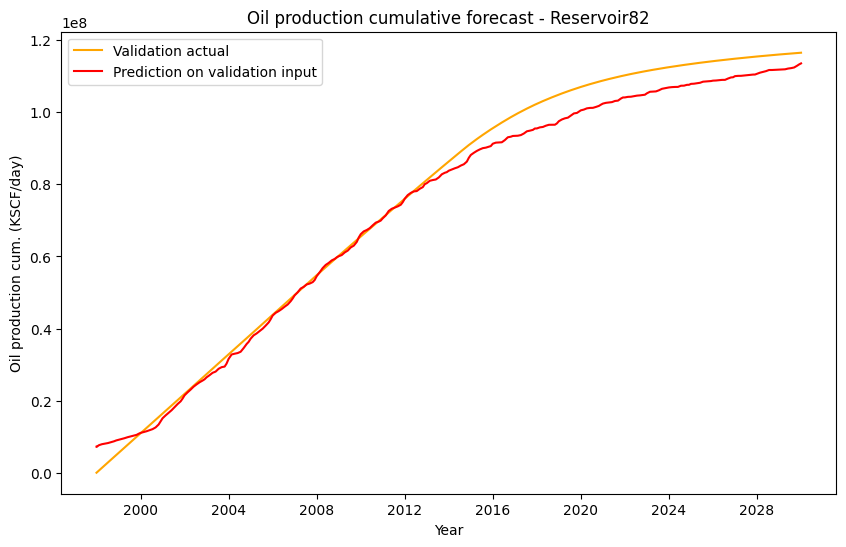

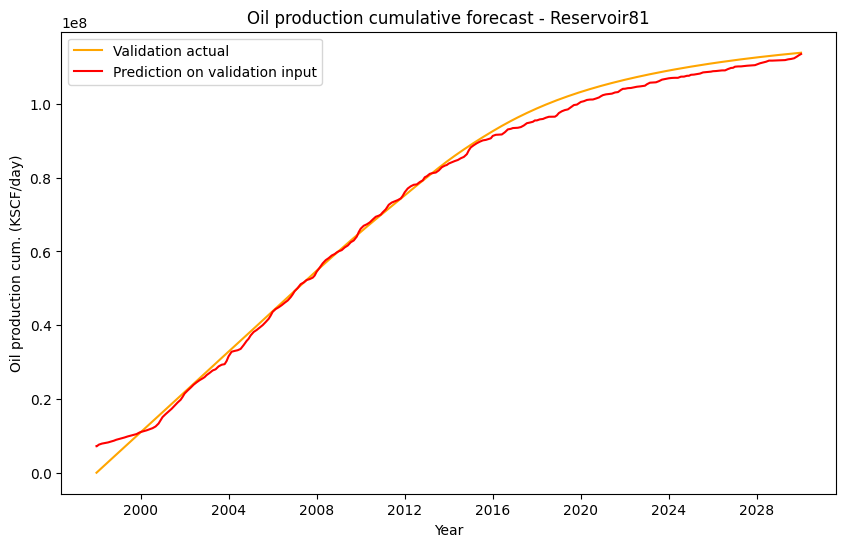

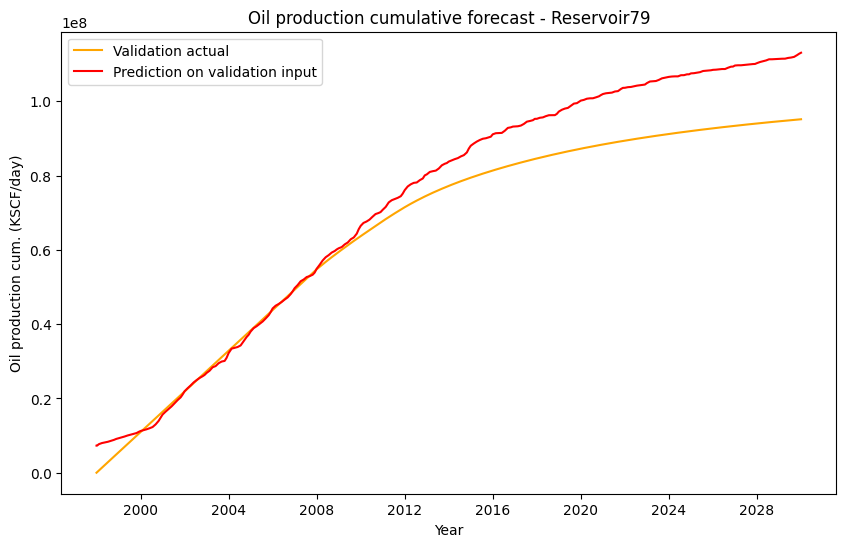

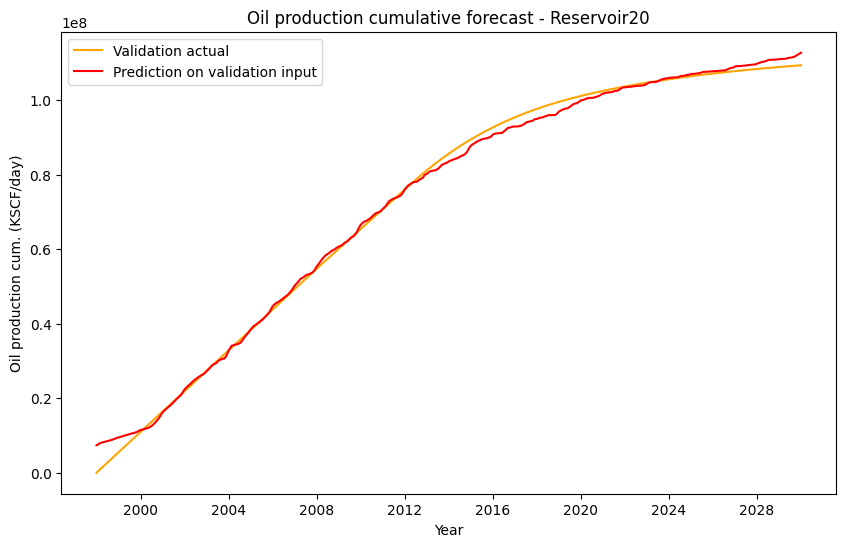

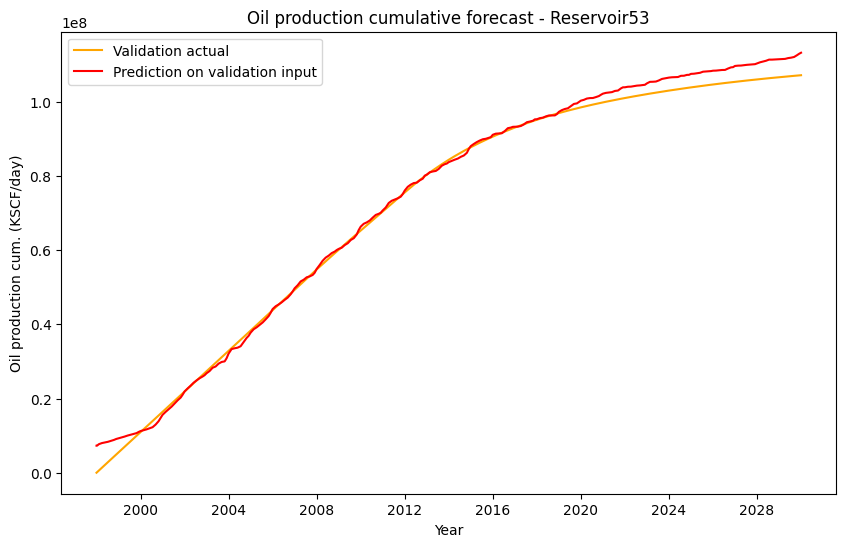

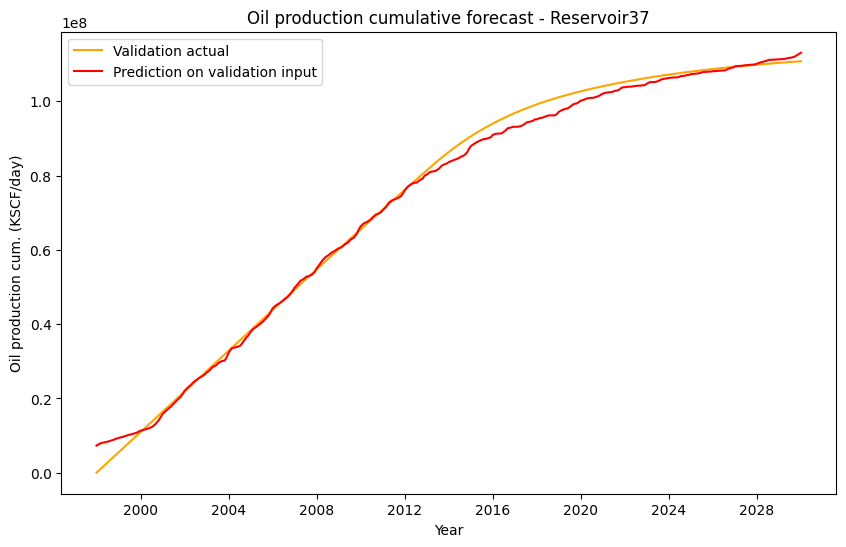

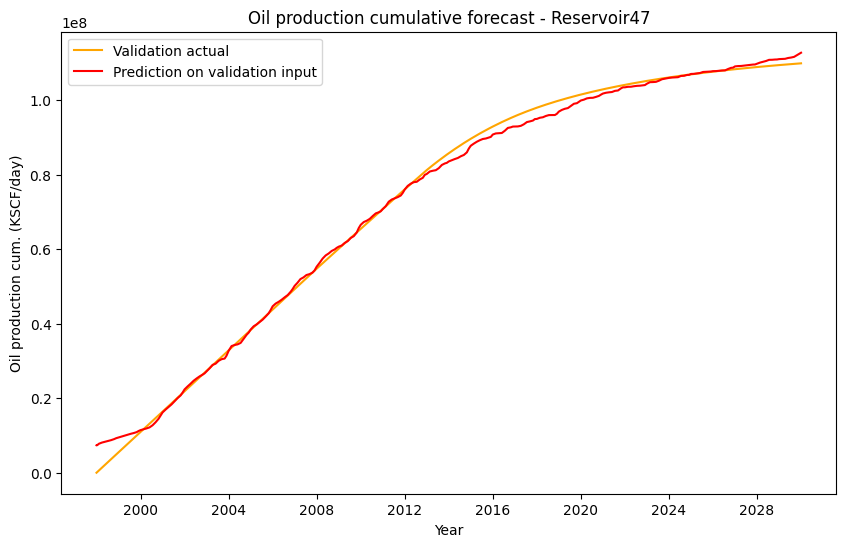

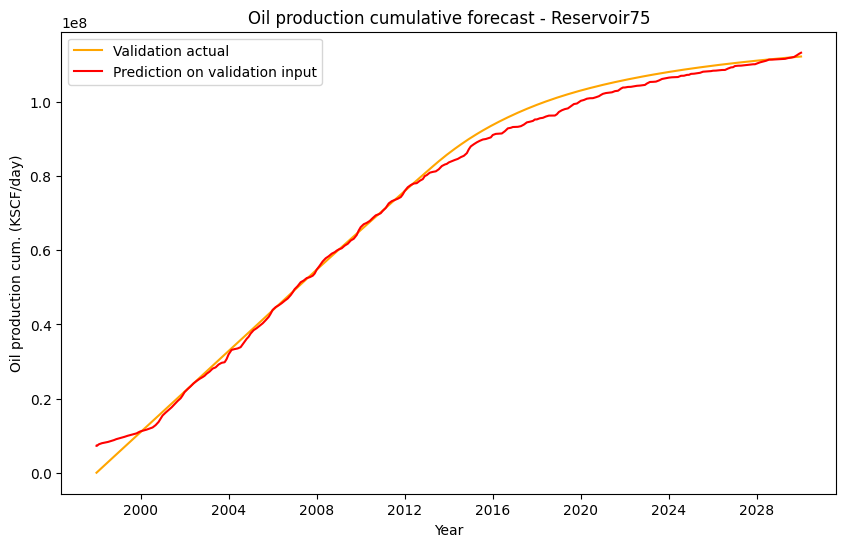

In [76]:
for i in range(26):
  plot_all_validation_res_oil(i)

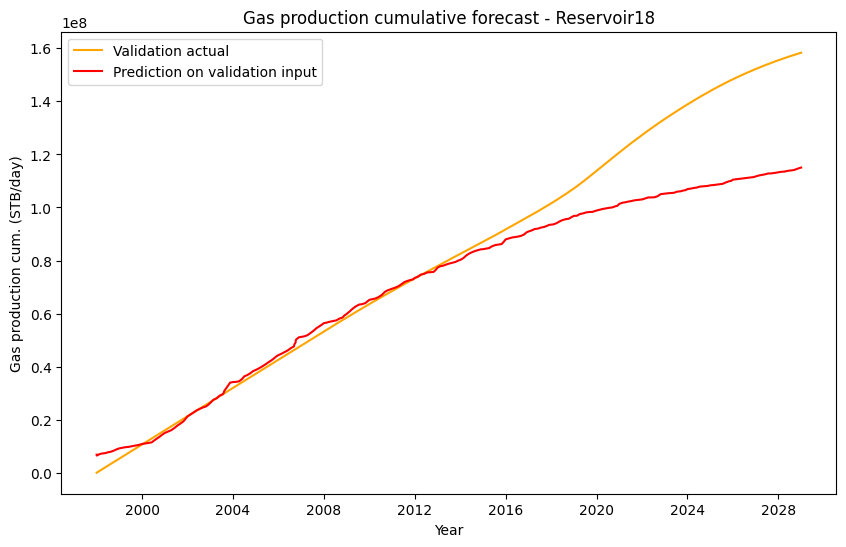

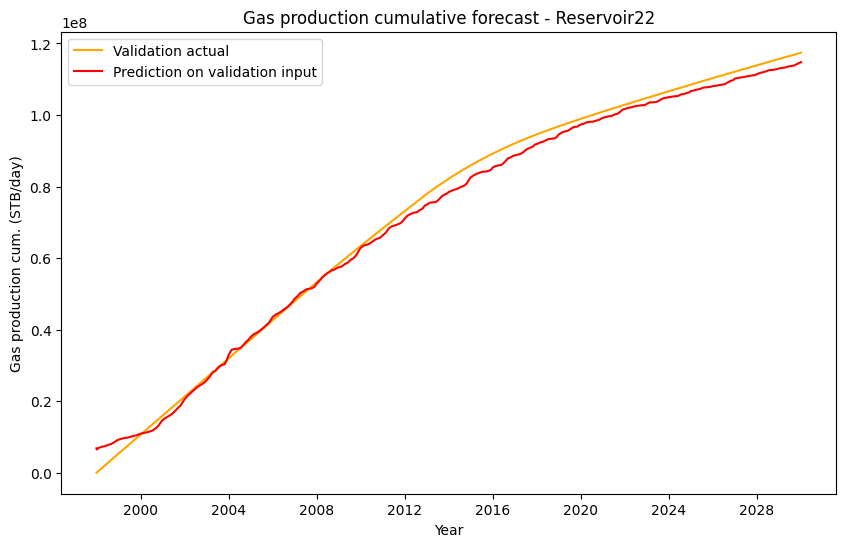

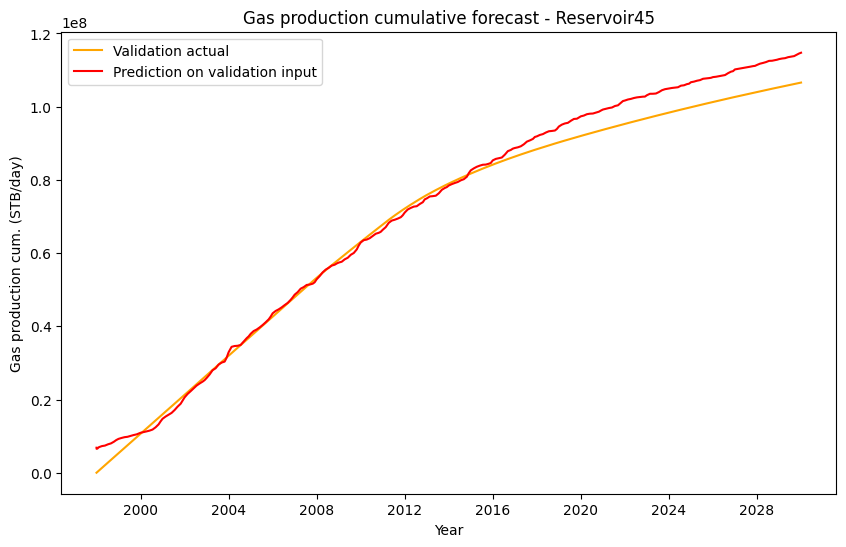

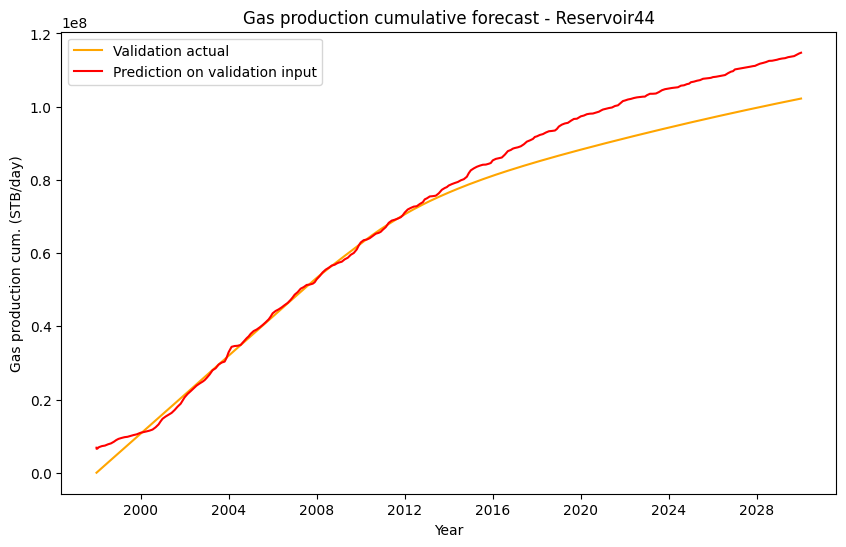

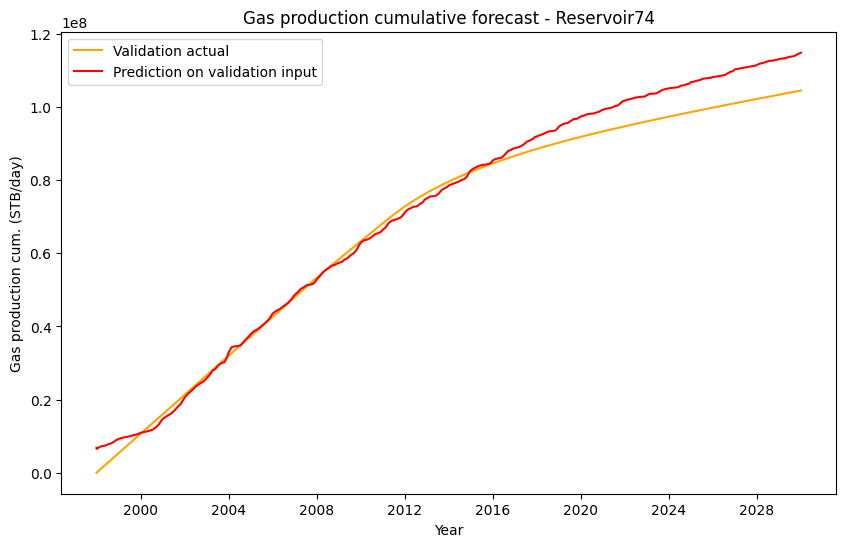

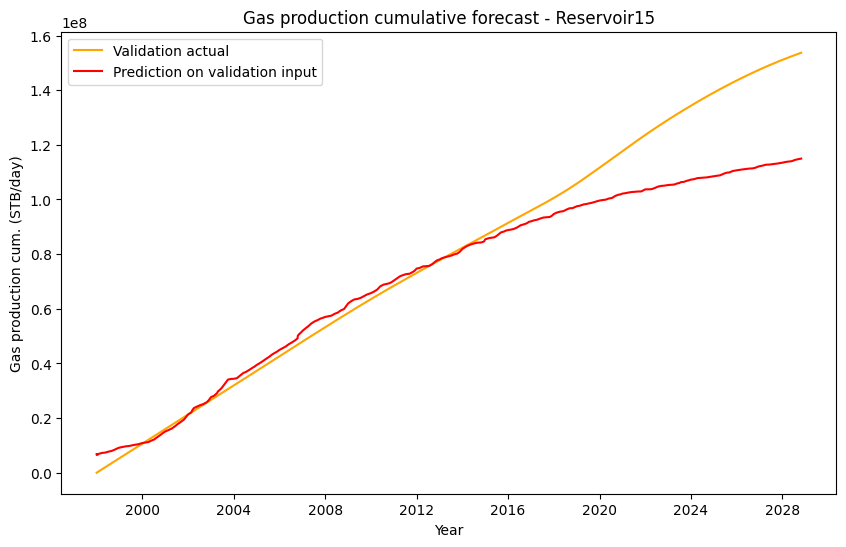

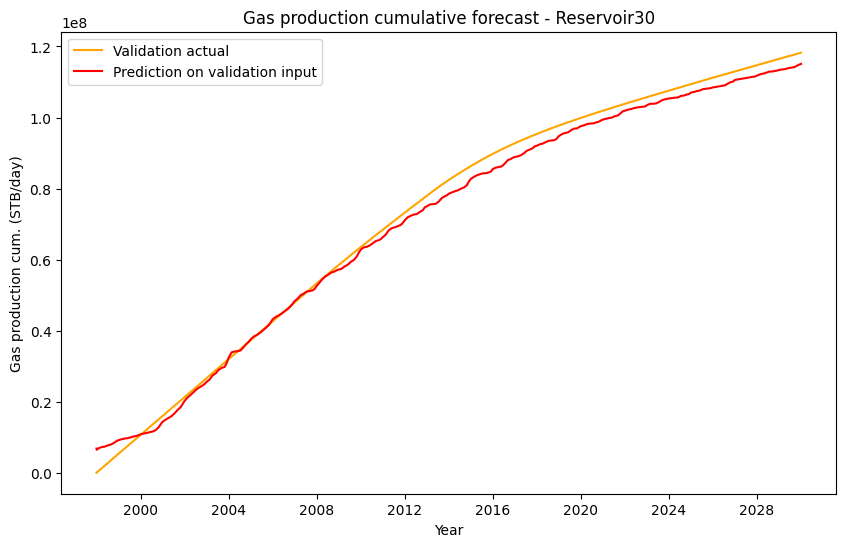

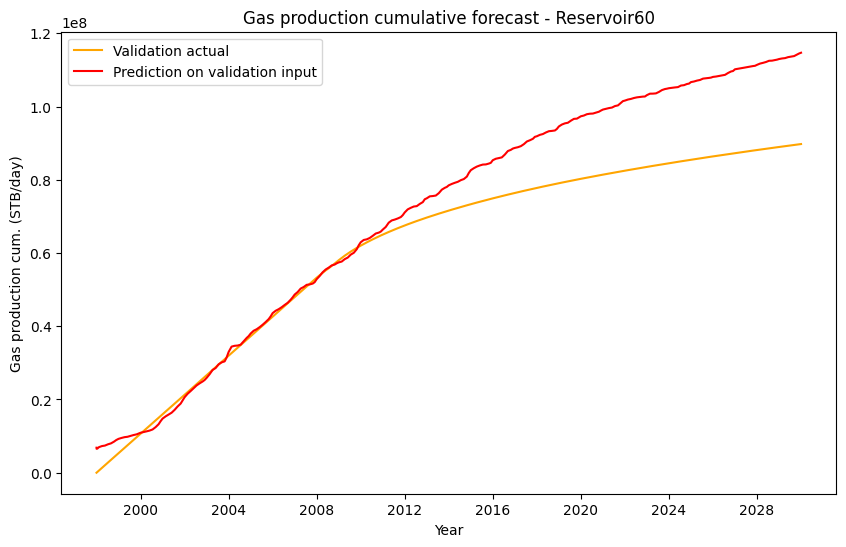

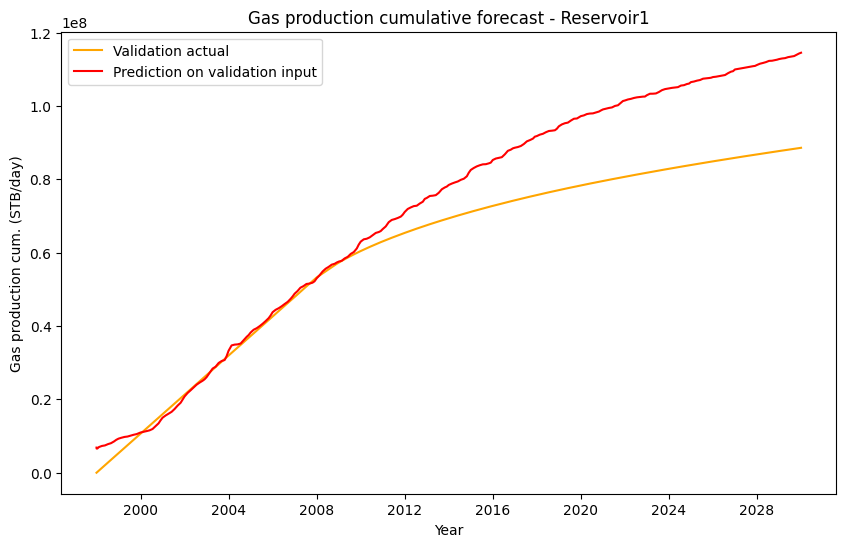

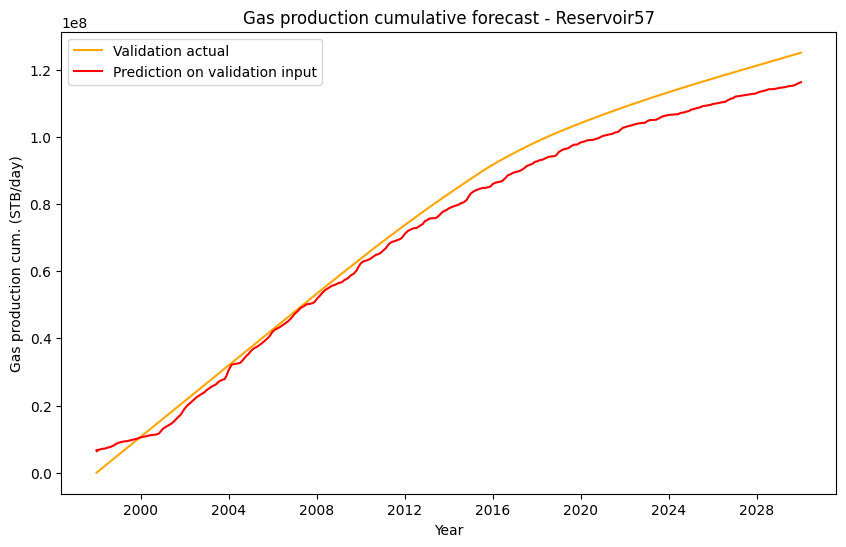

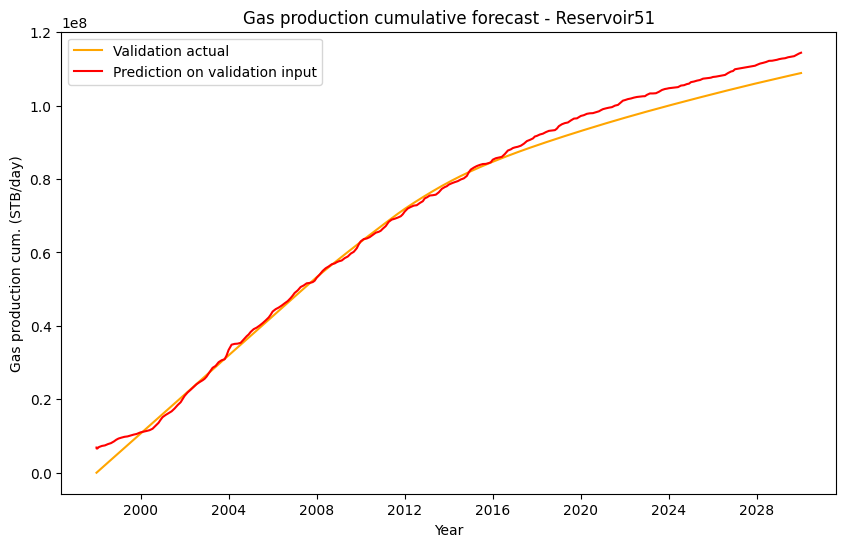

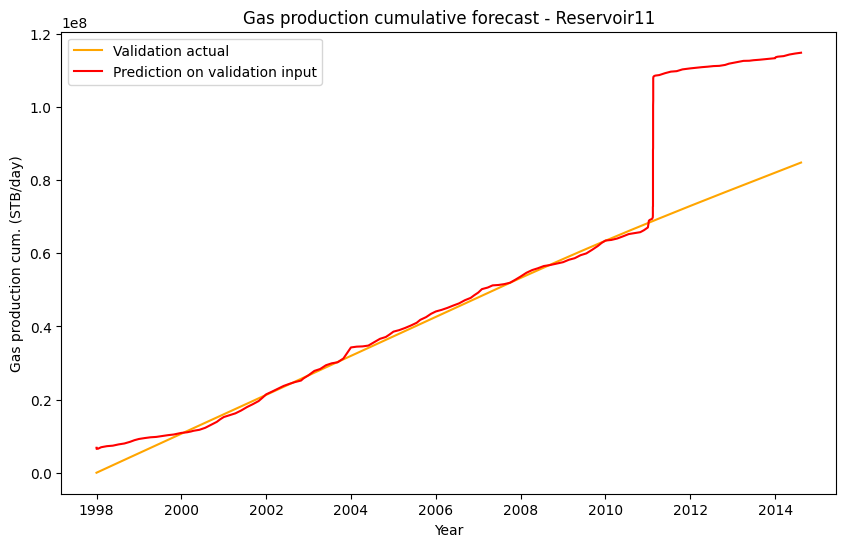

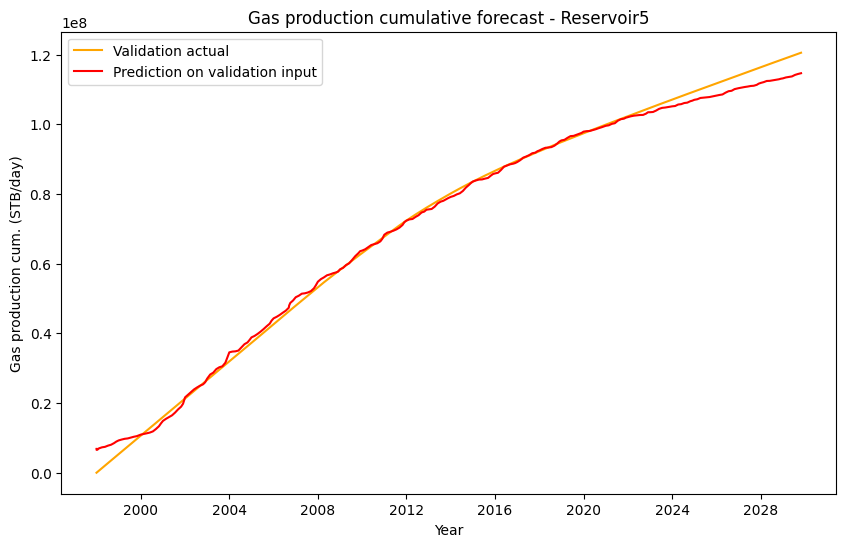

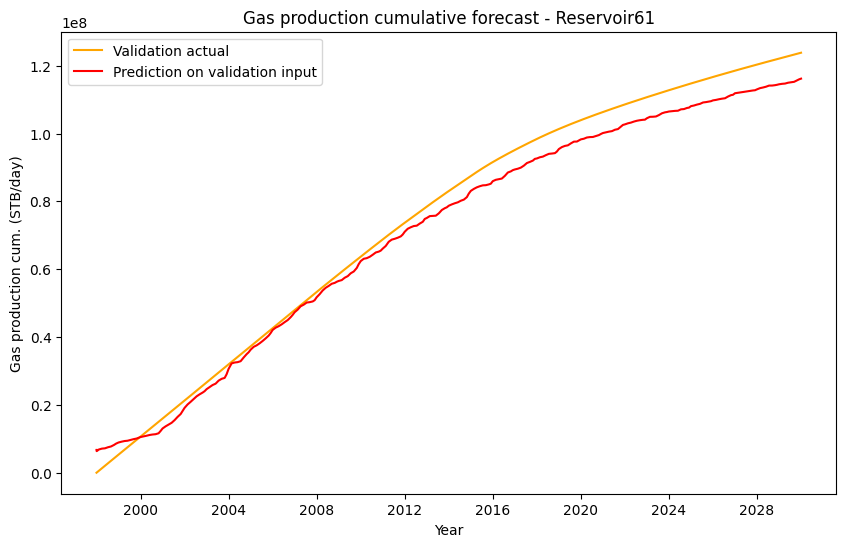

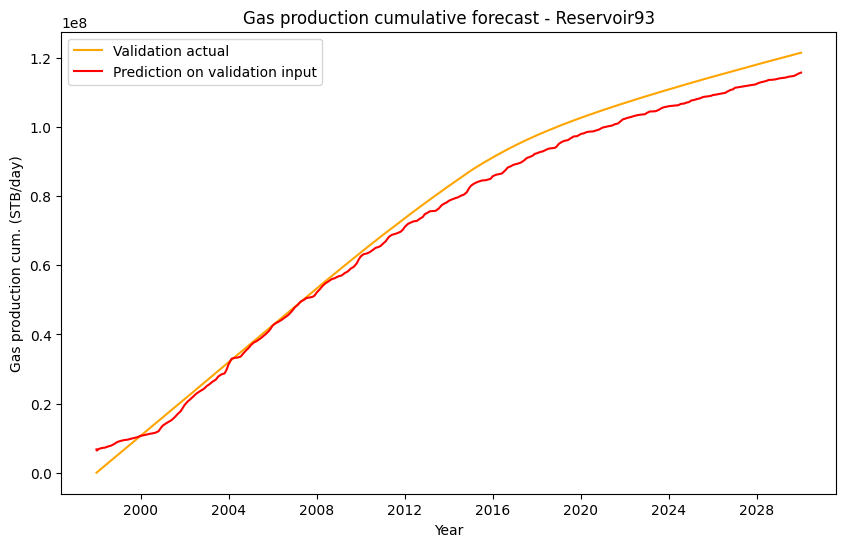

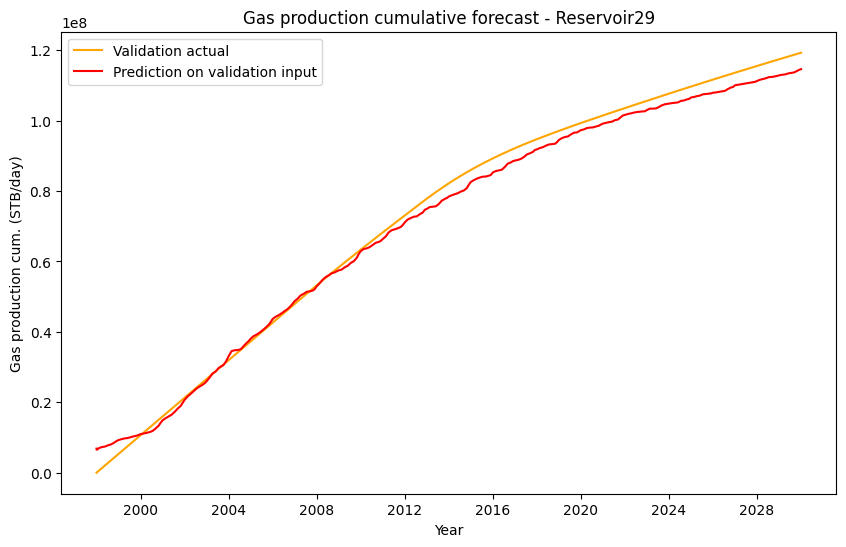

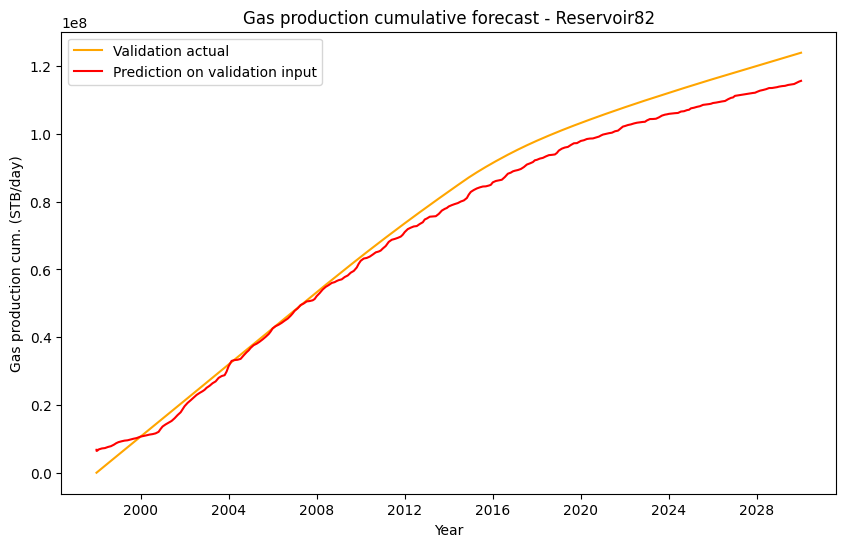

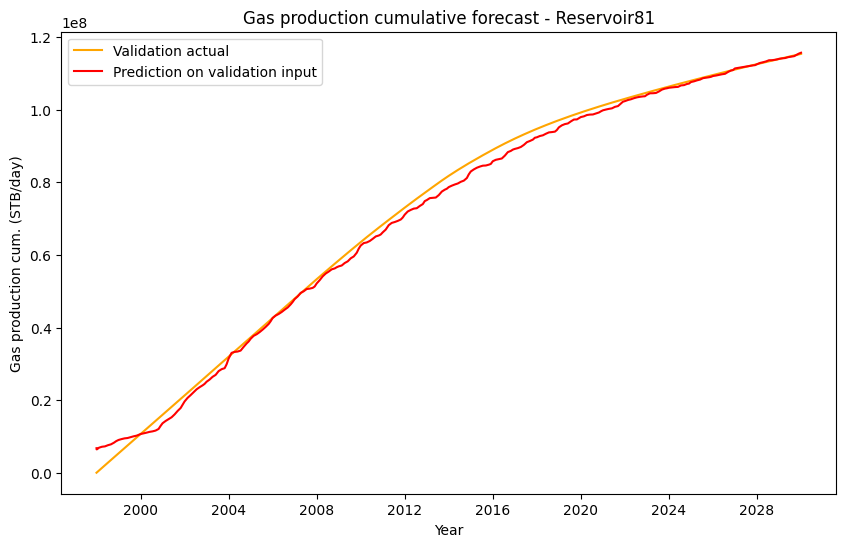

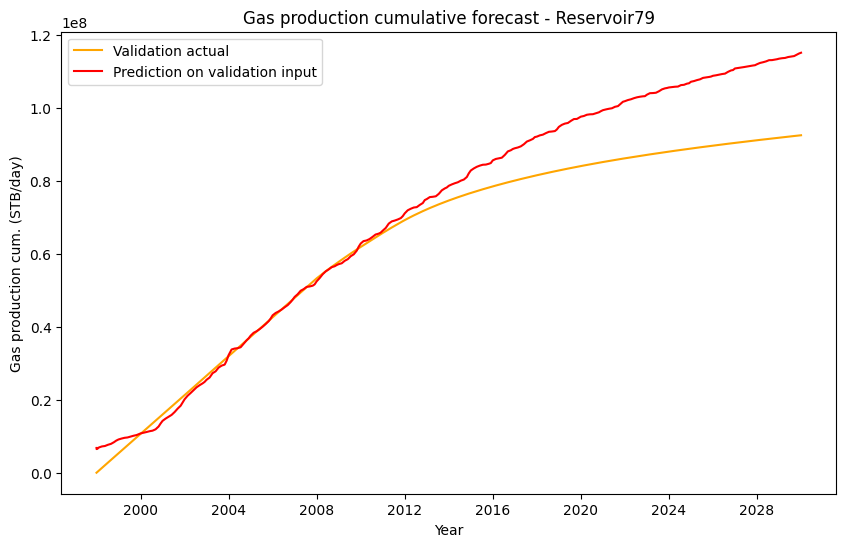

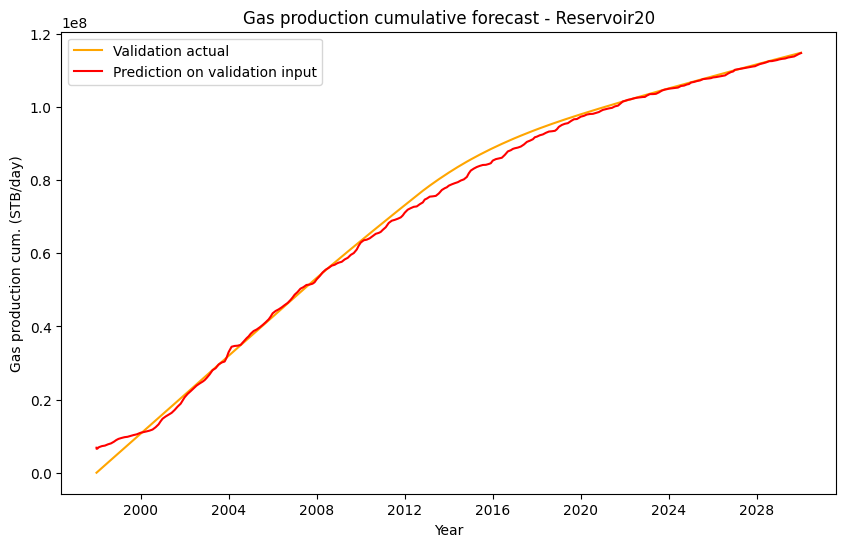

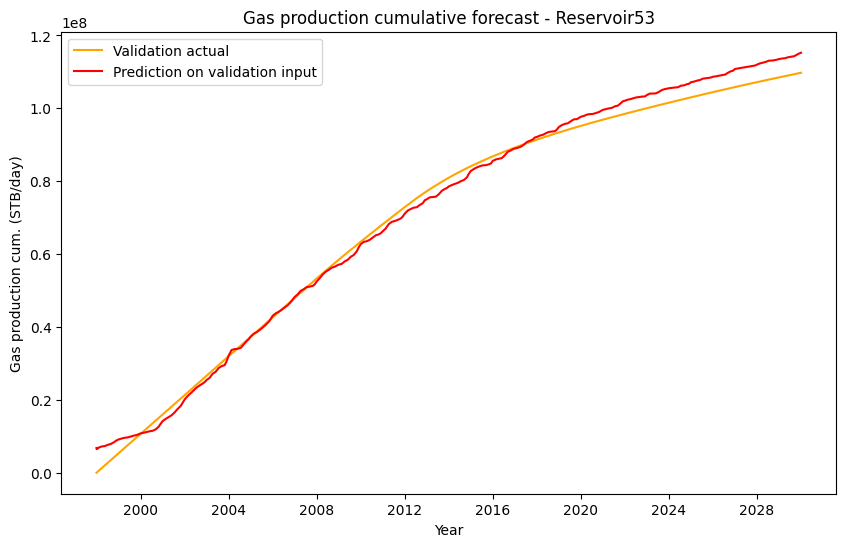

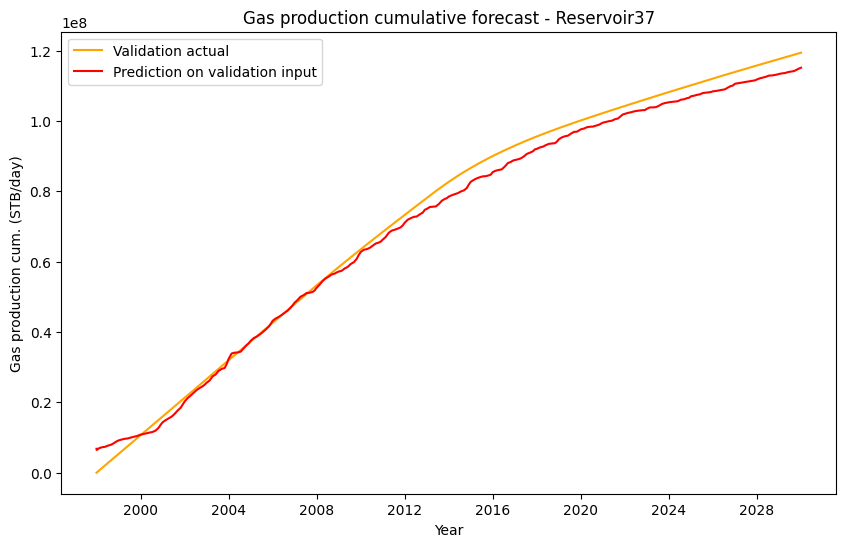

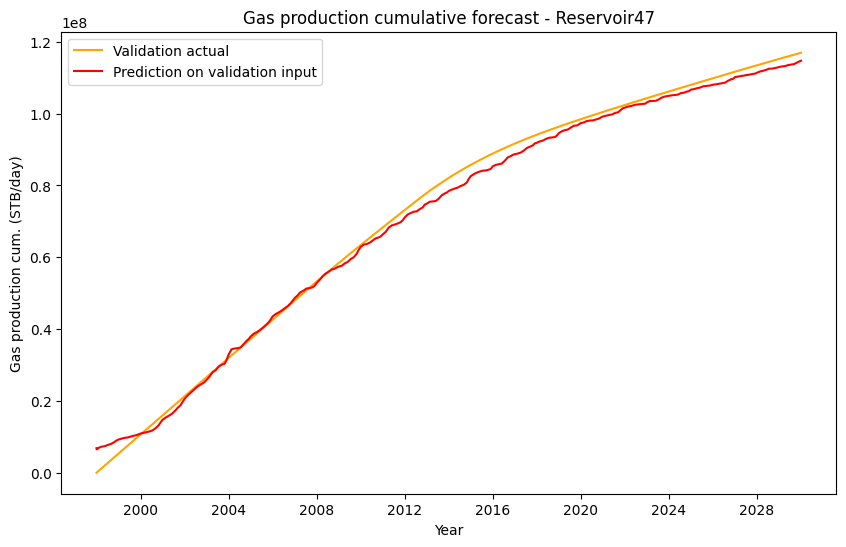

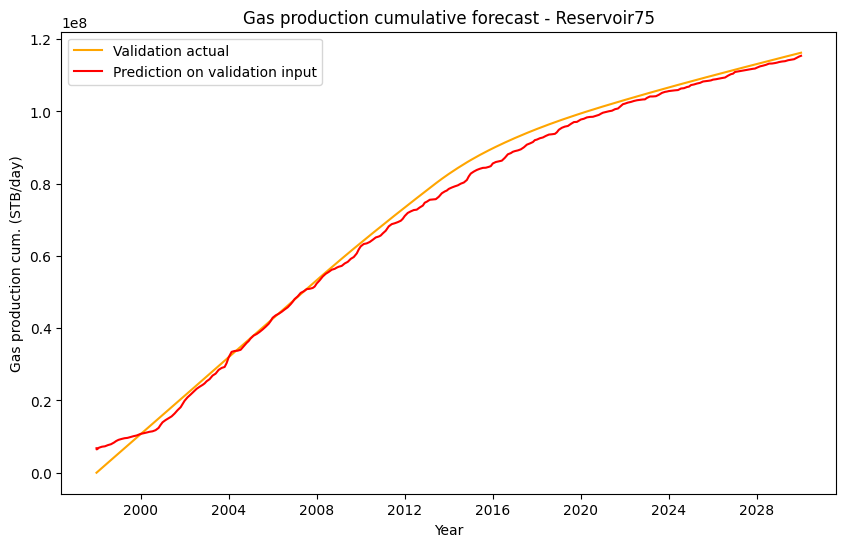

In [77]:
for i in range(26):
  plot_all_validation_res_gas(i)

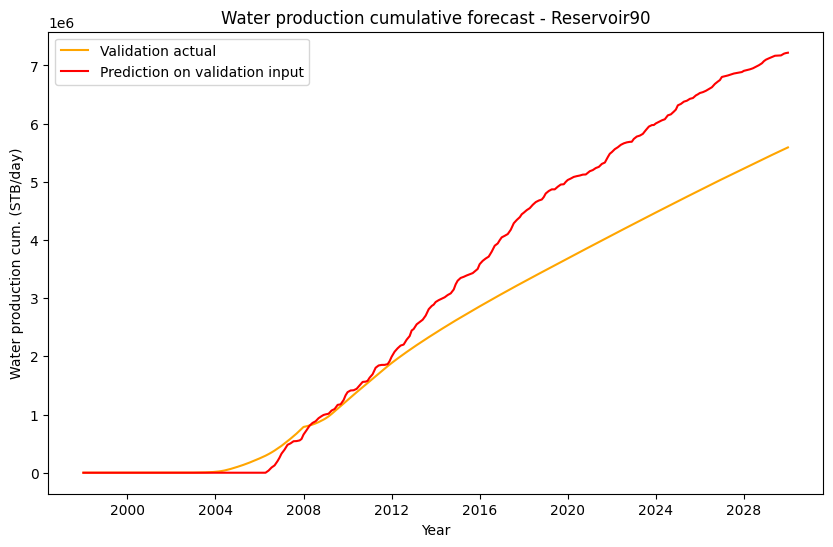

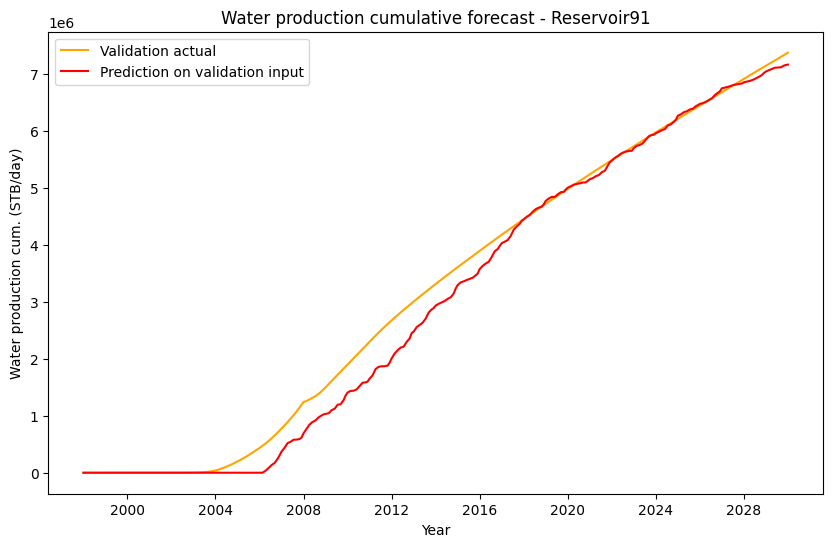

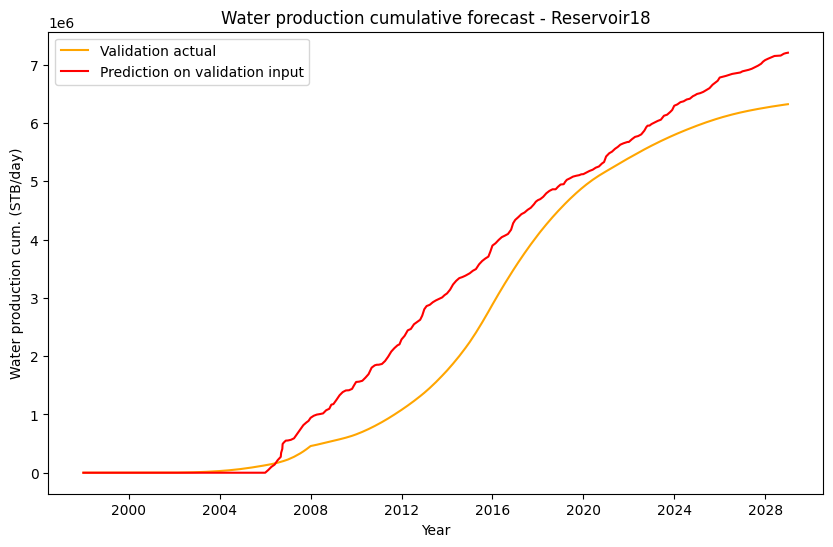

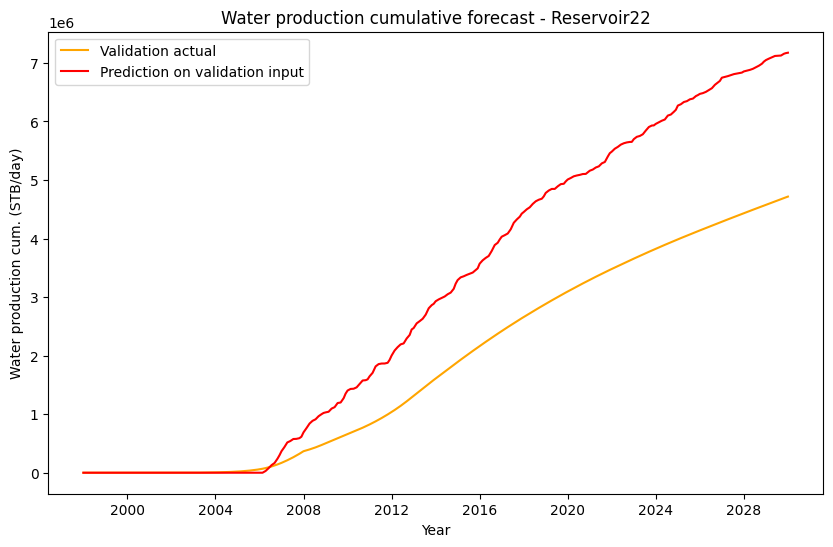

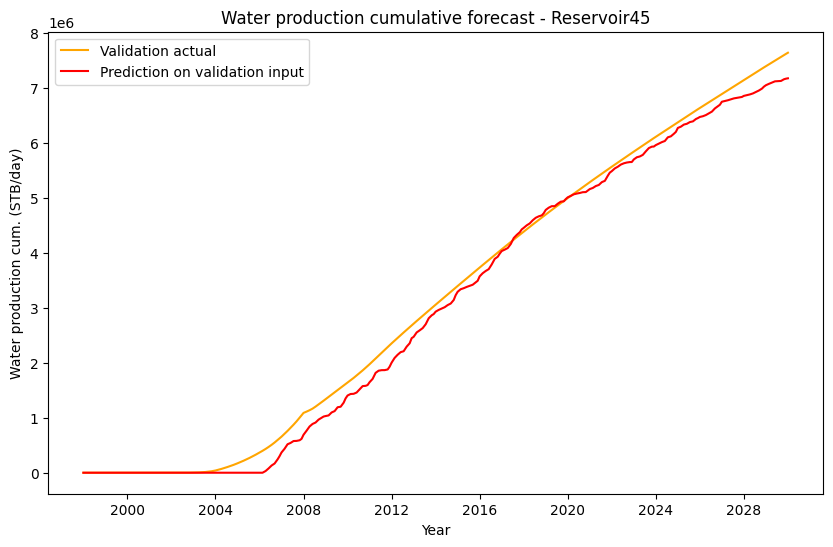

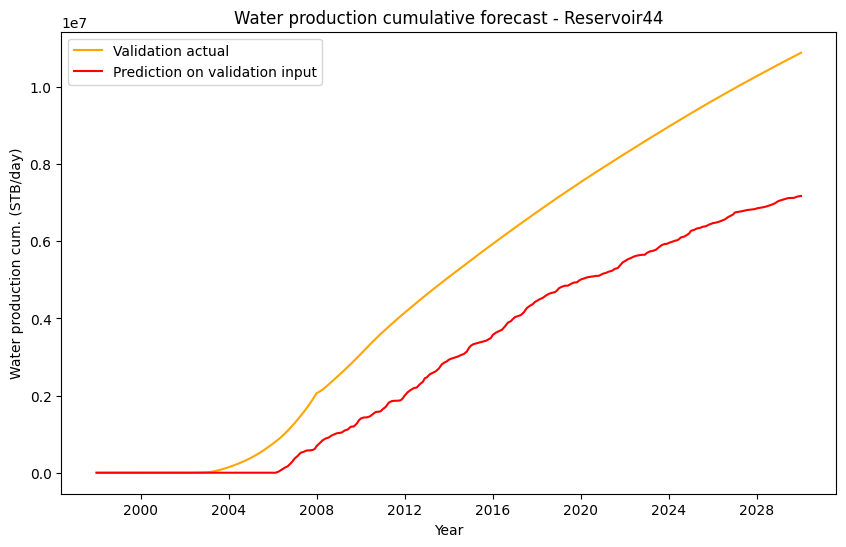

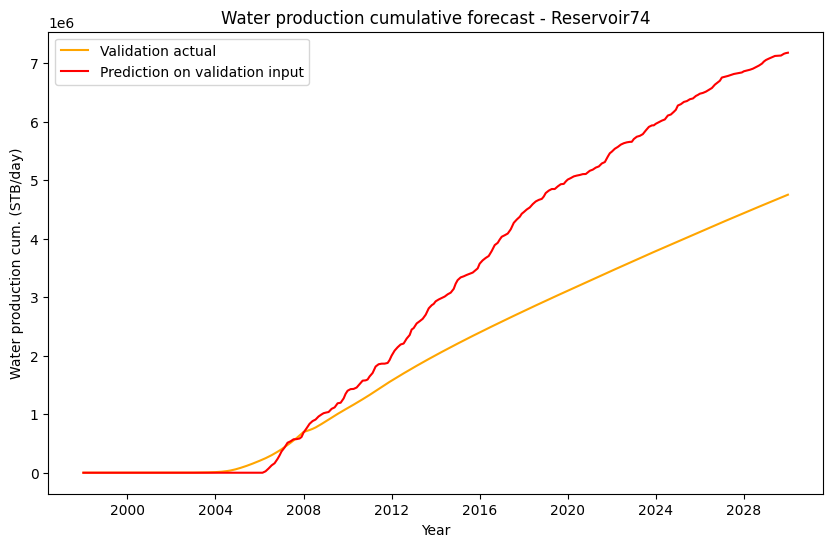

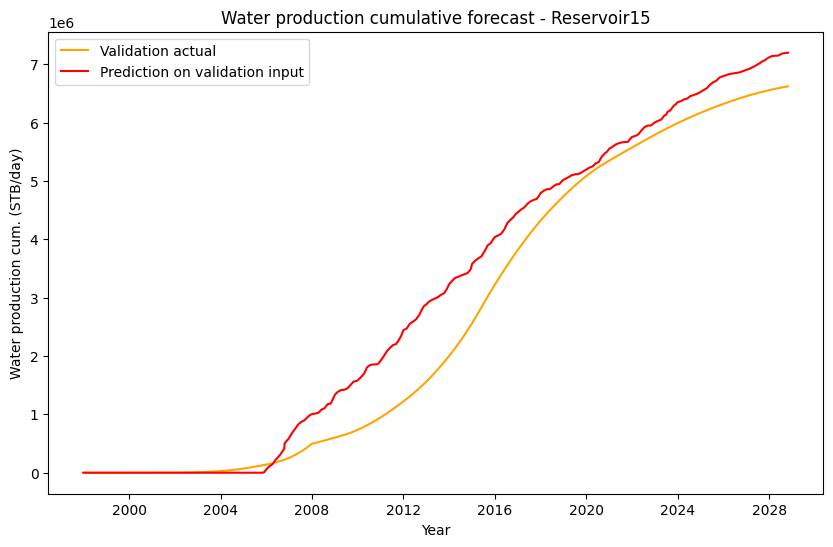

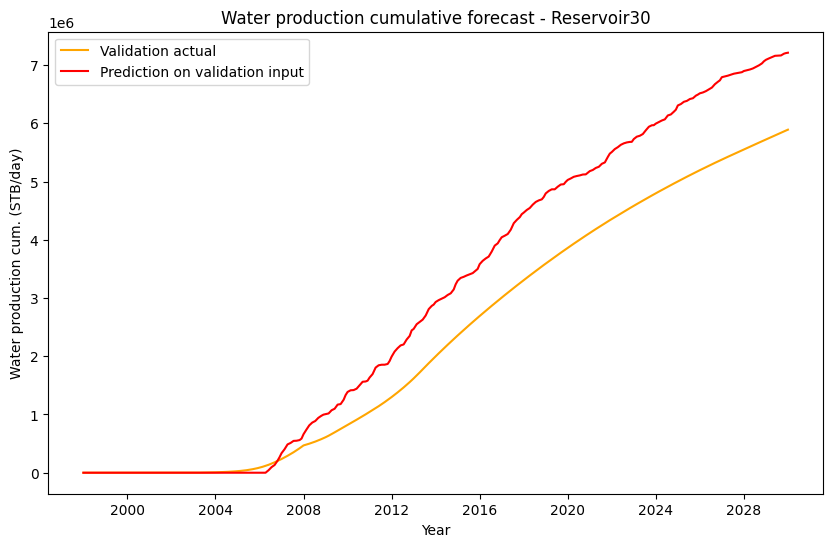

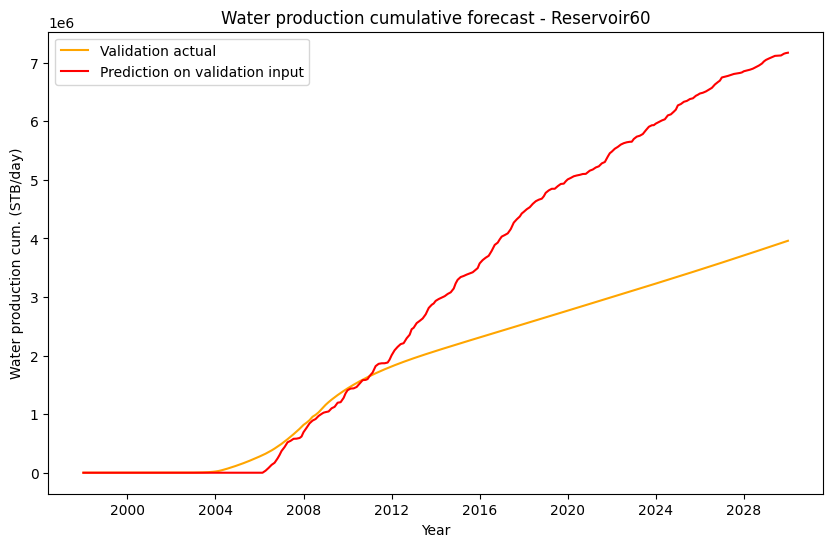

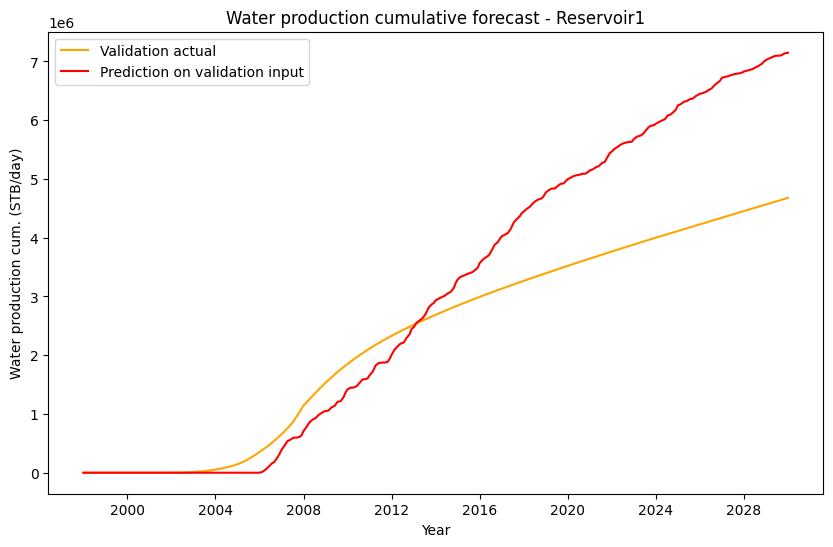

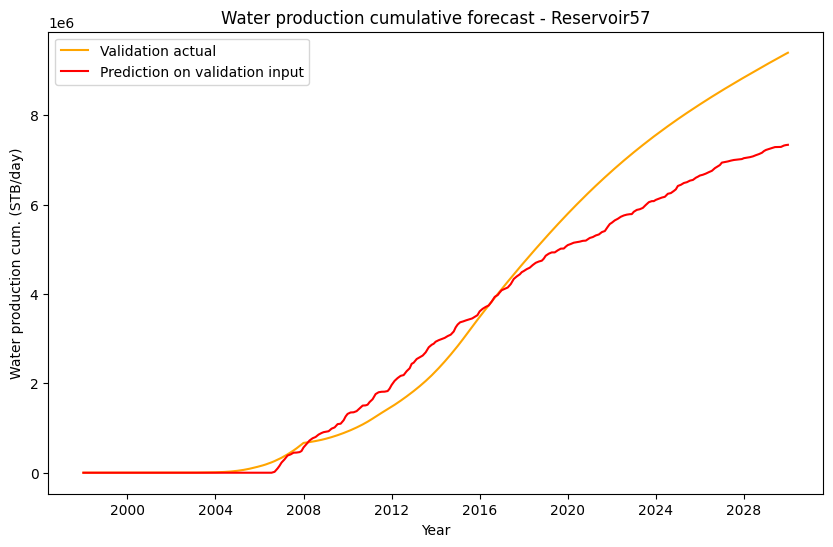

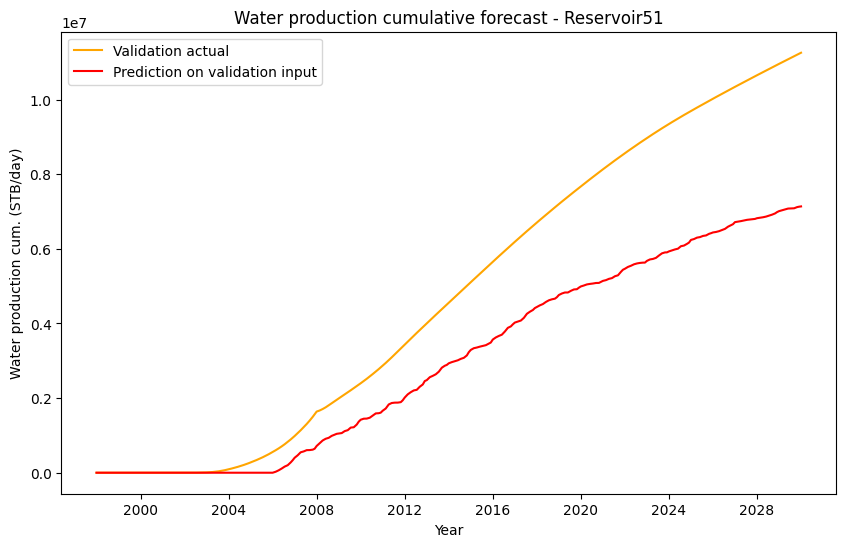

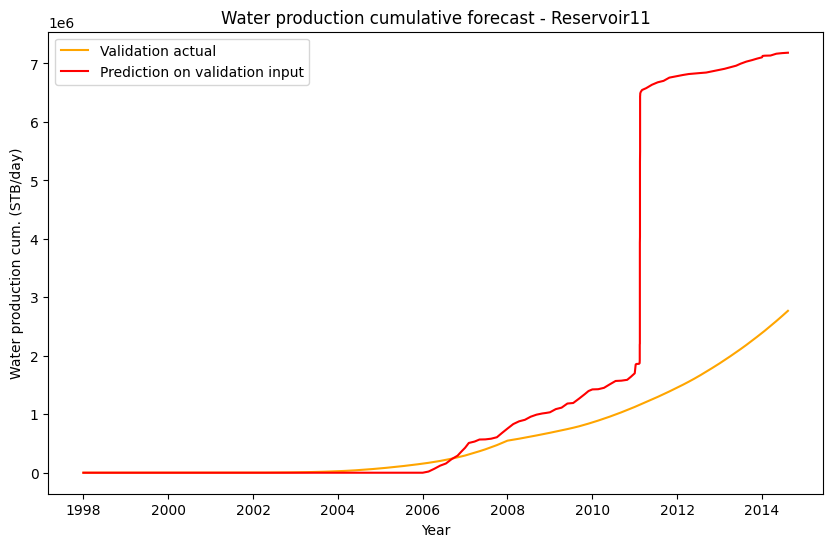

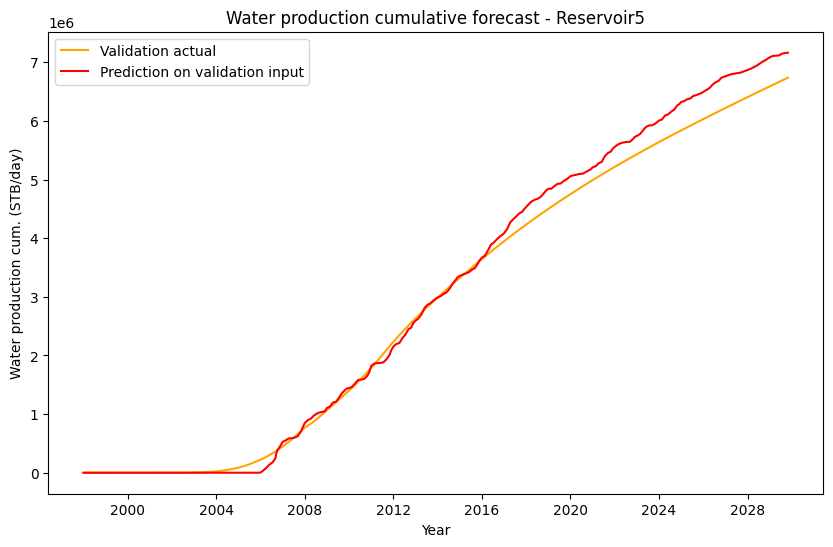

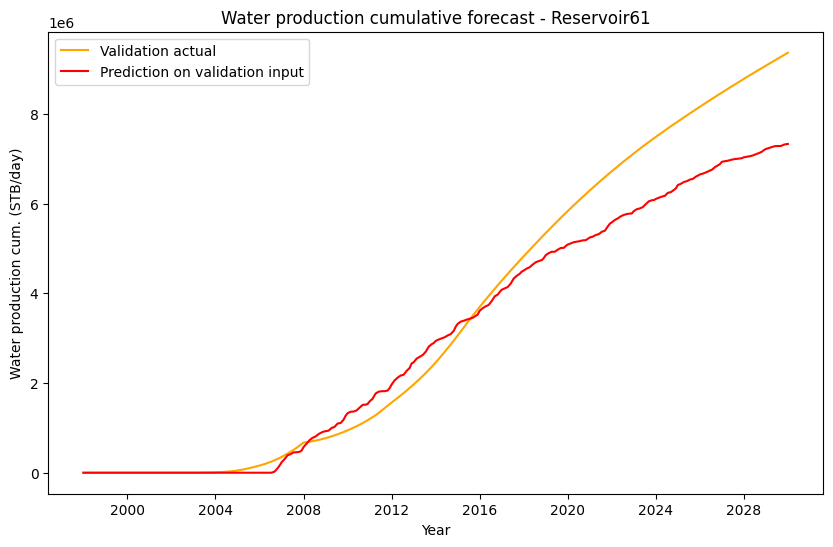

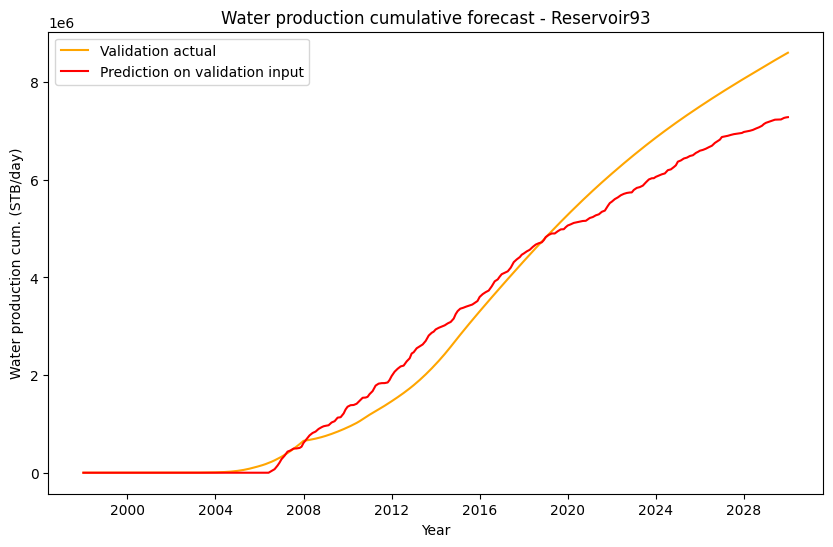

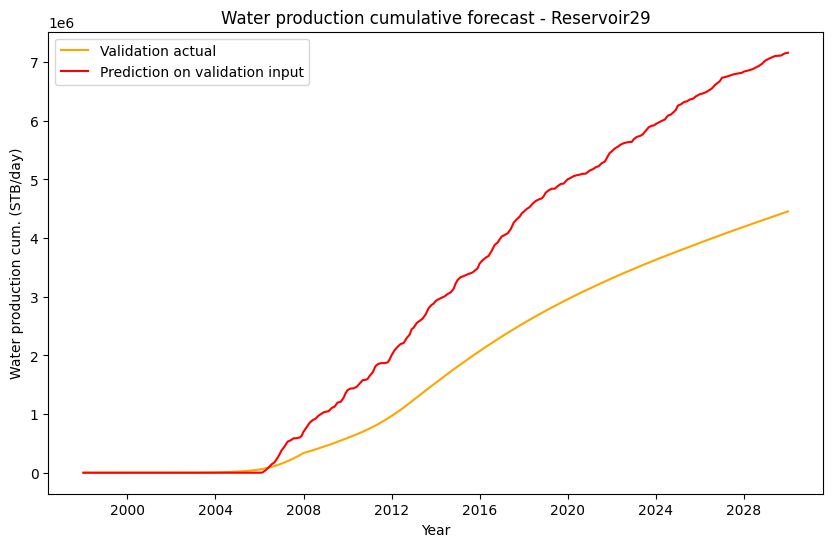

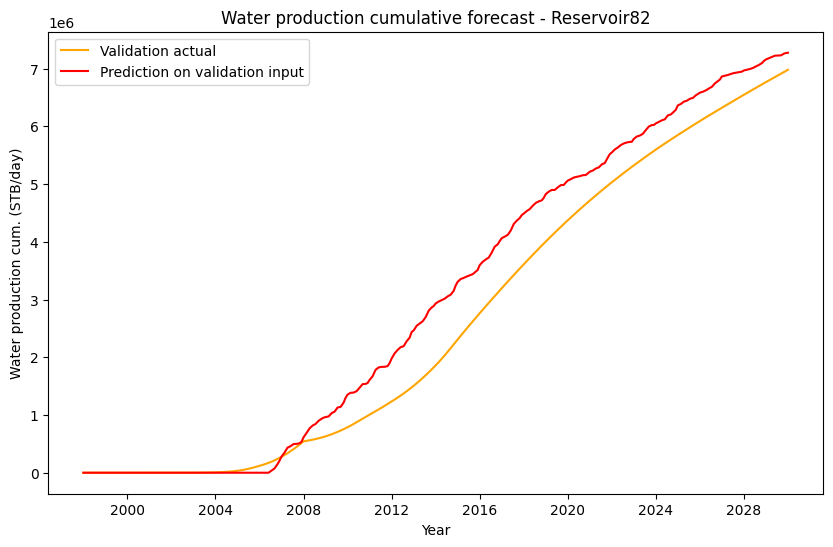

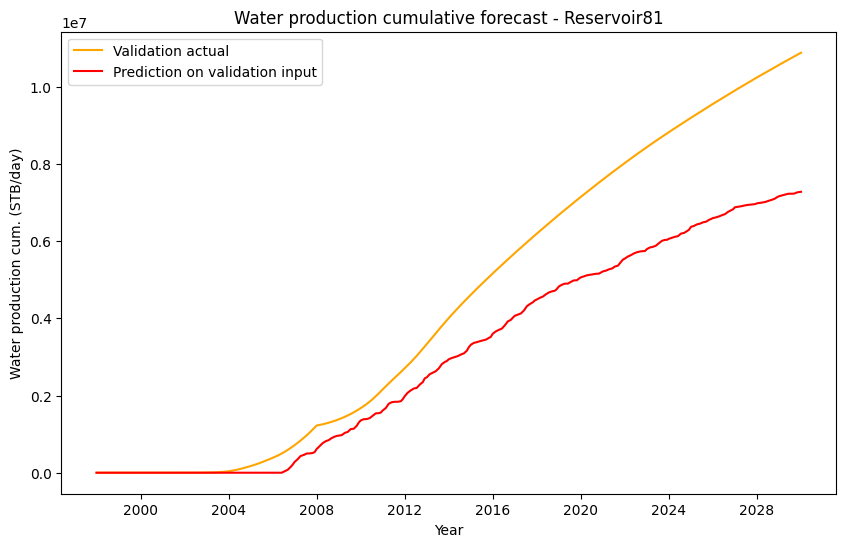

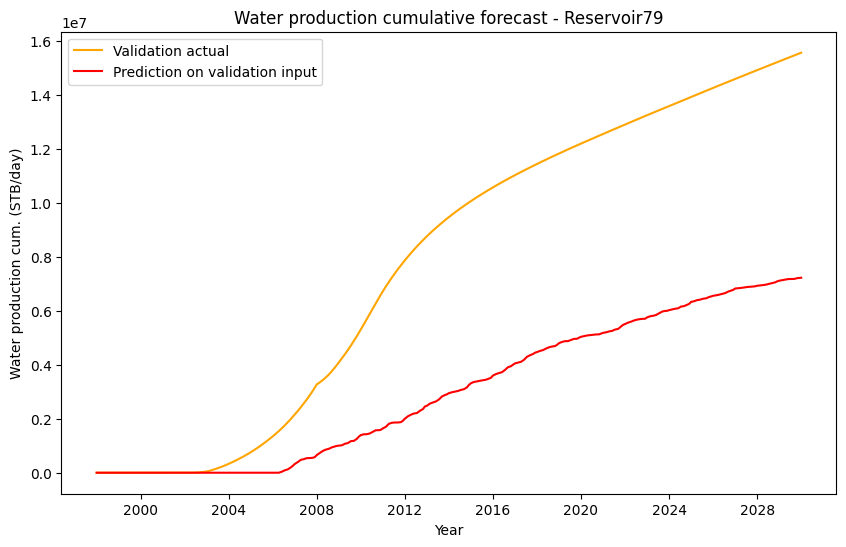

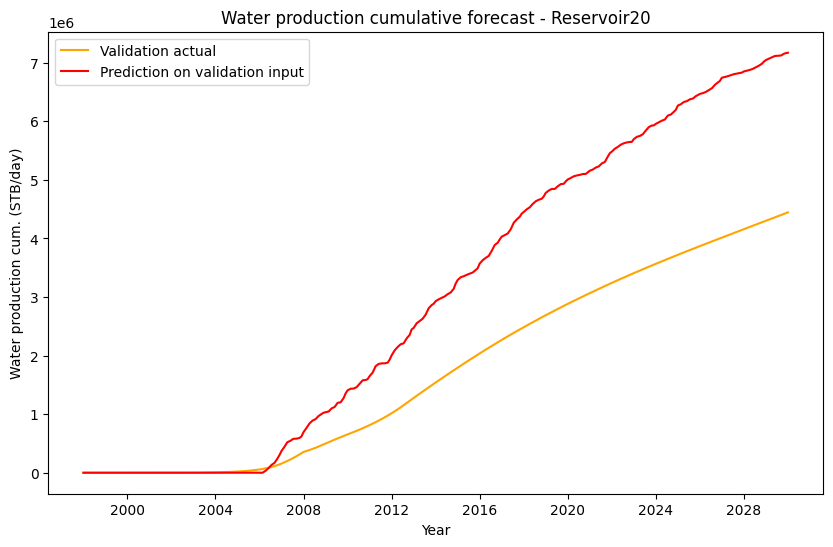

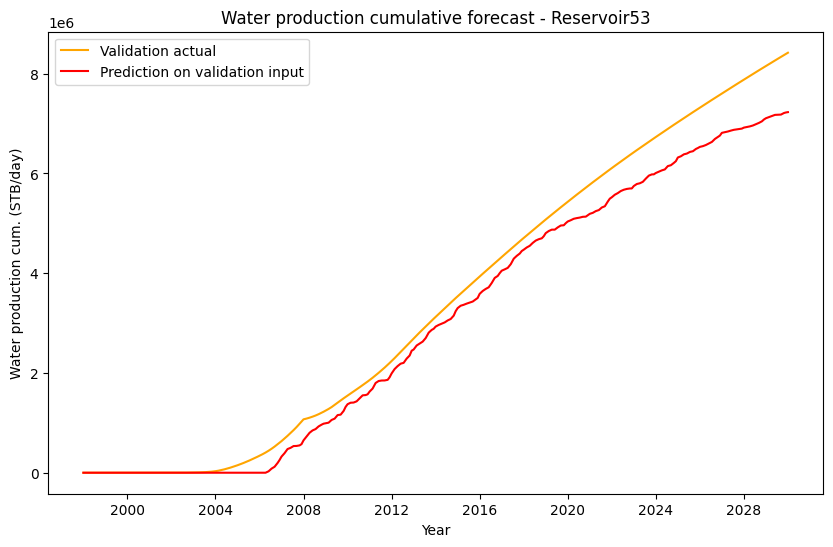

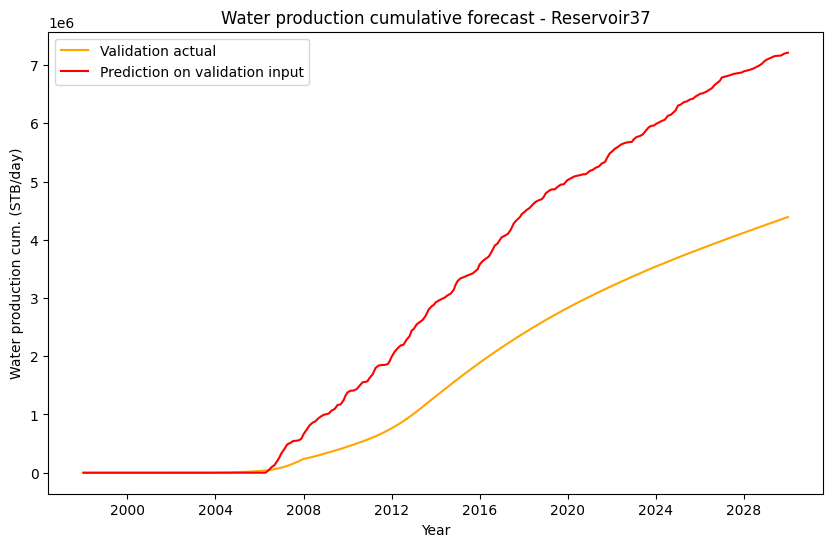

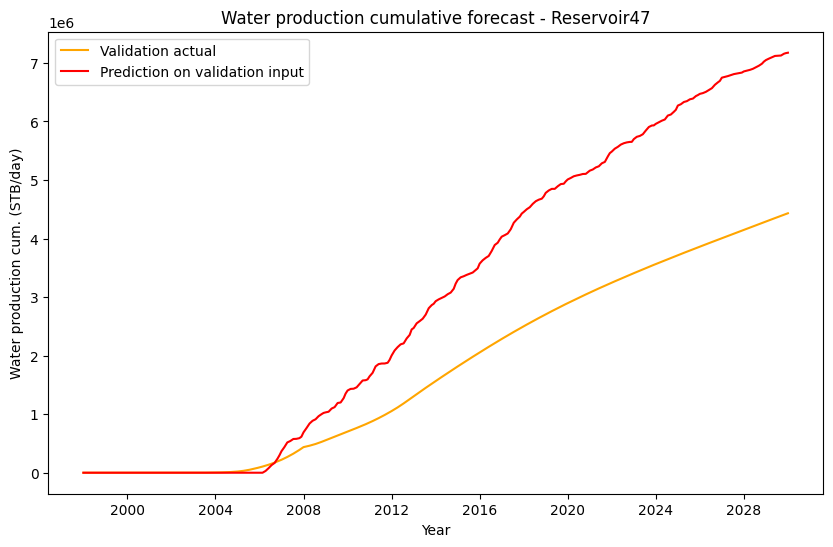

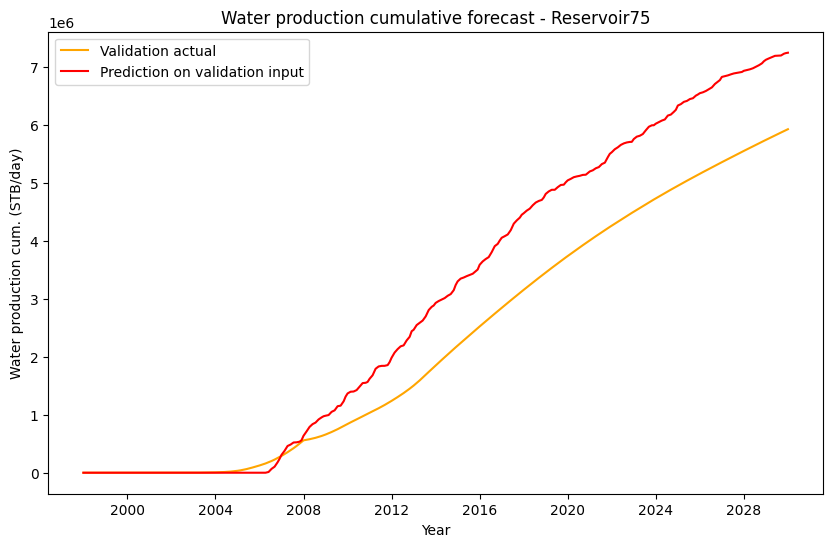

In [79]:
for i in range(26):
  plot_all_validation_res_water(i)

Zip all the validation graphs

In [80]:
!zip -r PNA_validation_graphs_gas.zip '/content/validation_graphs_gas'
!zip -r PNA_validation_graphs_oil.zip '/content/validation_graphs_oil'
!zip -r PNA_validation_graphs_water.zip '/content/validation_graphs_water'

updating: content/validation_graphs_gas/ (stored 0%)
updating: content/validation_graphs_gas/Reservoir5.png (deflated 17%)
updating: content/validation_graphs_gas/Reservoir45.png (deflated 17%)
updating: content/validation_graphs_gas/Reservoir15.png (deflated 17%)
updating: content/validation_graphs_gas/Reservoir91.png (deflated 17%)
updating: content/validation_graphs_gas/Reservoir29.png (deflated 17%)
updating: content/validation_graphs_gas/Reservoir60.png (deflated 17%)
updating: content/validation_graphs_gas/Reservoir22.png (deflated 16%)
updating: content/validation_graphs_gas/Reservoir90.png (deflated 17%)
updating: content/validation_graphs_gas/Reservoir53.png (deflated 16%)
updating: content/validation_graphs_gas/Reservoir37.png (deflated 16%)
updating: content/validation_graphs_gas/Reservoir20.png (deflated 16%)
updating: content/validation_graphs_gas/Reservoir82.png (deflated 16%)
updating: content/validation_graphs_gas/Reservoir79.png (deflated 17%)
updating: content/validat

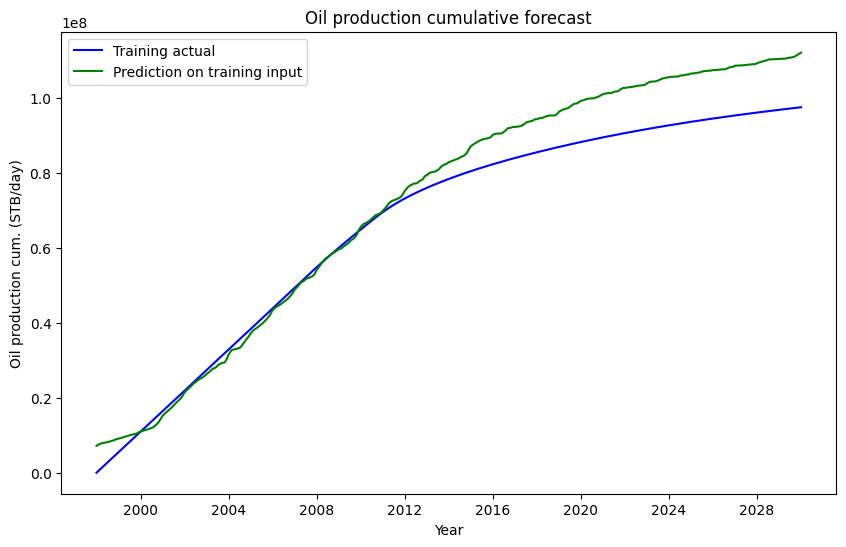

In [81]:
plt.figure(figsize=(10, 6))
train_reservoir = 1

plt.plot(df_outputs_list[train_reservoir][:260].index, df_outputs_list[train_reservoir][:260]['Oil production cumulative'], label='Training actual', color='blue')
plt.plot(df_outputs_list[train_reservoir][:260].index, train_predictions[train_reservoir][:, 1:2], label='Prediction on training input',color='green')

plt.title('Oil production cumulative forecast')
plt.xlabel('Year')
plt.ylabel('Oil production cum. (STB/day)')
plt.legend()
plt.show()

Create folder to store combined validation plots

In [30]:
!mkdir validation_plots_combined

Function to generate combined validation plots

In [57]:
def plot_all_validation_res_combined(reservoir):
  plt.figure(figsize=(10, 6))

  plt.plot(df_outputs_list_validation[reservoir][:260].index, df_outputs_list_validation[reservoir][:260]['Oil production cumulative'], label='Oil validation actual', color='red', linestyle='--')
  plt.plot(df_outputs_list_validation[reservoir][:260].index, validation_predictions[reservoir][:, 1:2], label='Oil validation prediction',color='red')

  plt.plot(df_outputs_list_validation[reservoir][:260].index, df_outputs_list_validation[reservoir][:260]['Water production cumulative'], label='Water validation actual', color='blue', linestyle='--')
  plt.plot(df_outputs_list_validation[reservoir][:260].index, validation_predictions[reservoir][:, 2:3], label='Water validation prediction',color='blue')

  plt.plot(df_outputs_list_validation[reservoir][:260].index, df_outputs_list_validation[reservoir][:260]['Gas production cumulative'], label='Gas validation actual', color='teal', linestyle='--')
  plt.plot(df_outputs_list_validation[reservoir][:260].index, validation_predictions[reservoir][:, 0:1], label='Gas validation prediction',color='teal')


  plt.title(f'Production cumulative forecast - {pathlist_to_validation[reservoir]}')
  plt.xlabel('Year')
  plt.ylabel('Production cum. (STB/day for Oil and Water, KSCF/day for Gas)')
  plt.legend()

  filename = '/content/validation_plots_combined/' + pathlist_to_validation[reservoir] + '.png'
  plt.savefig(filename, dpi=300)

  plt.show()

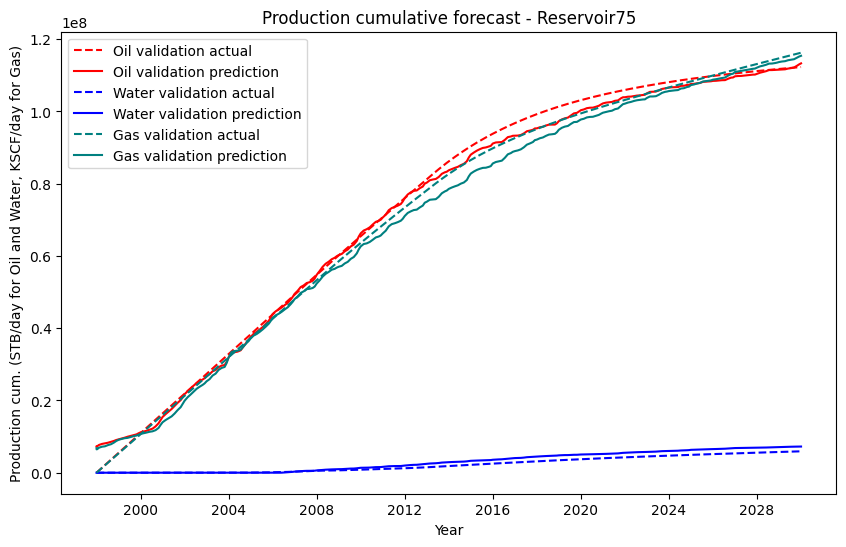

In [82]:
plot_all_validation_res_combined(25)

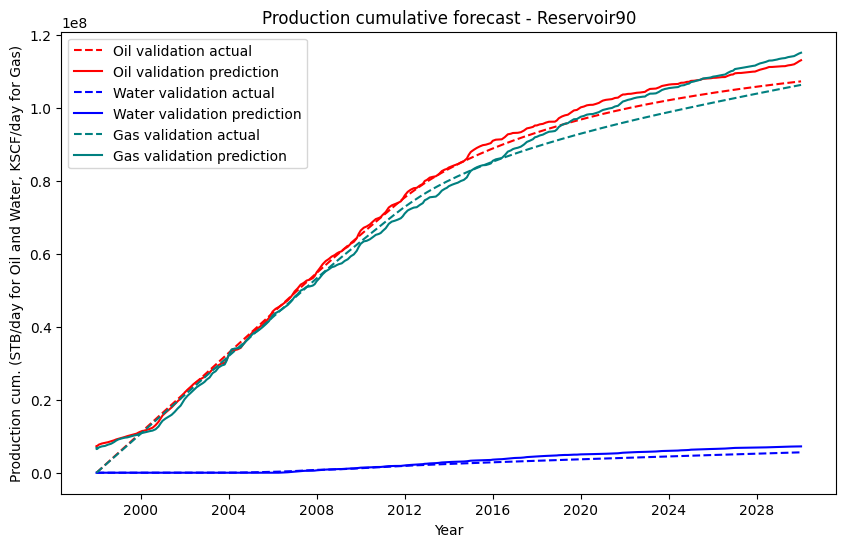

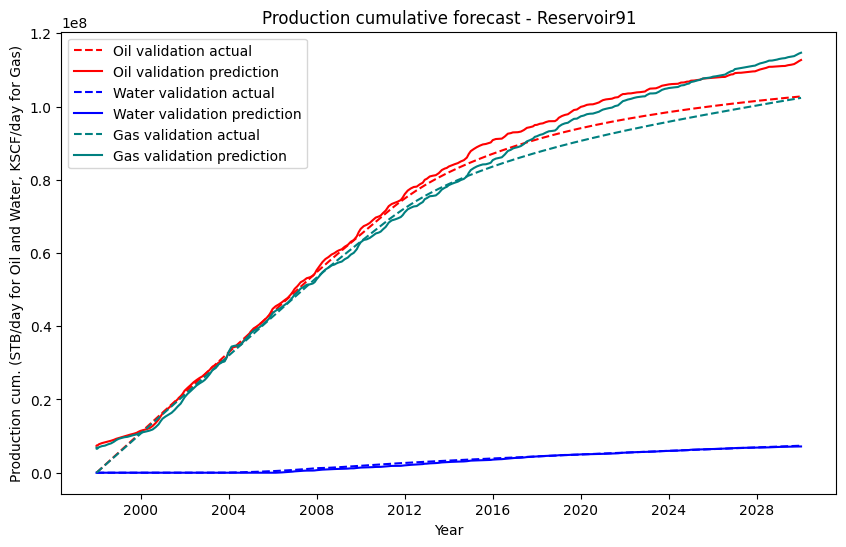

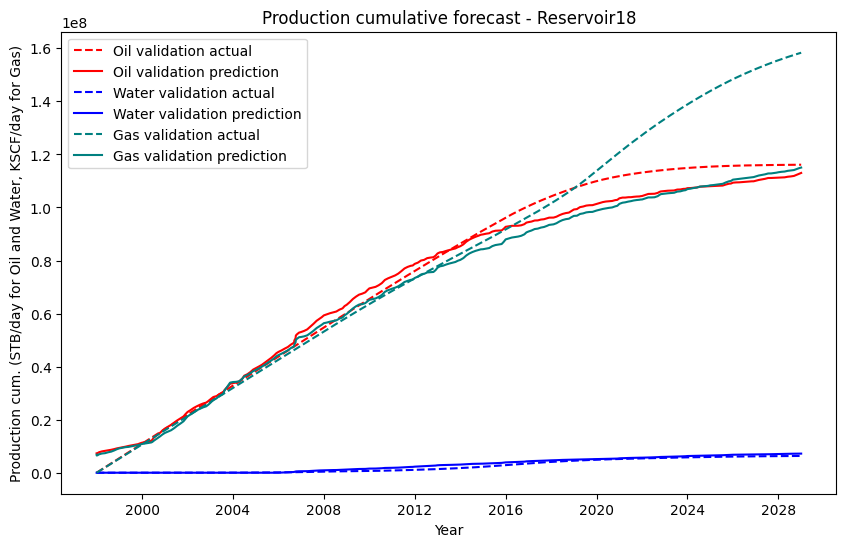

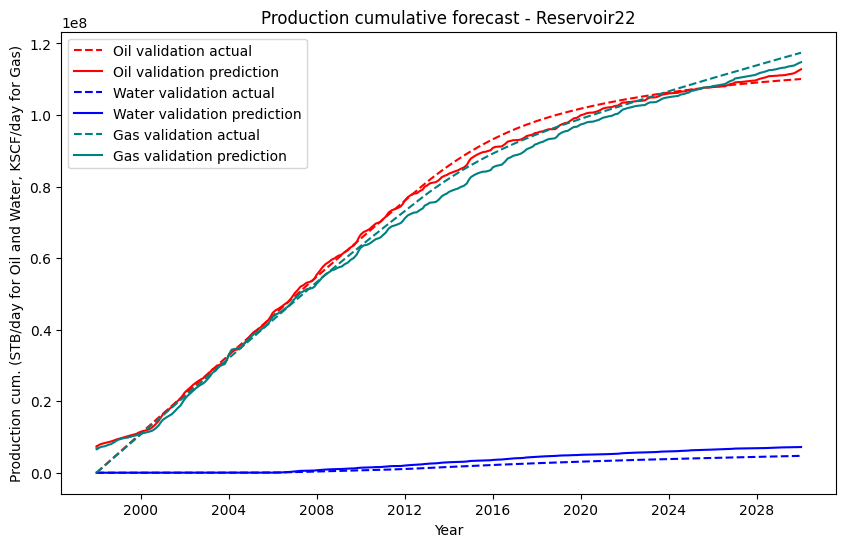

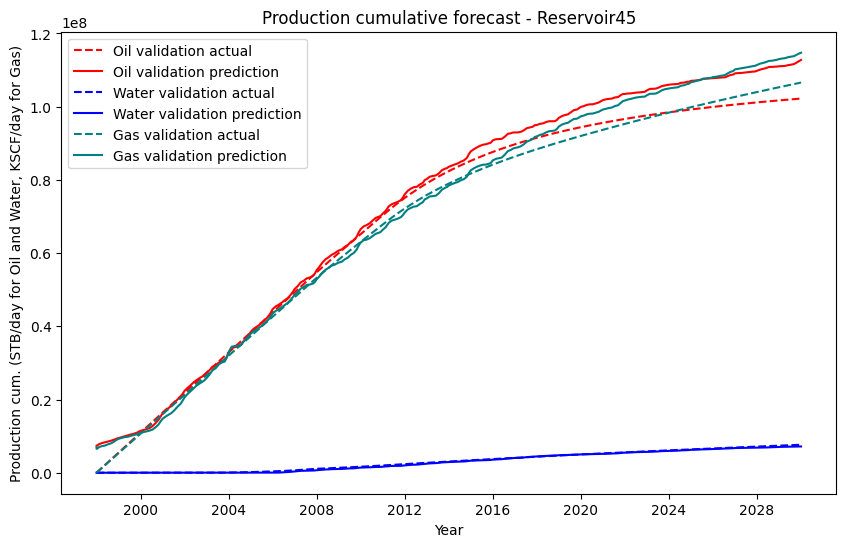

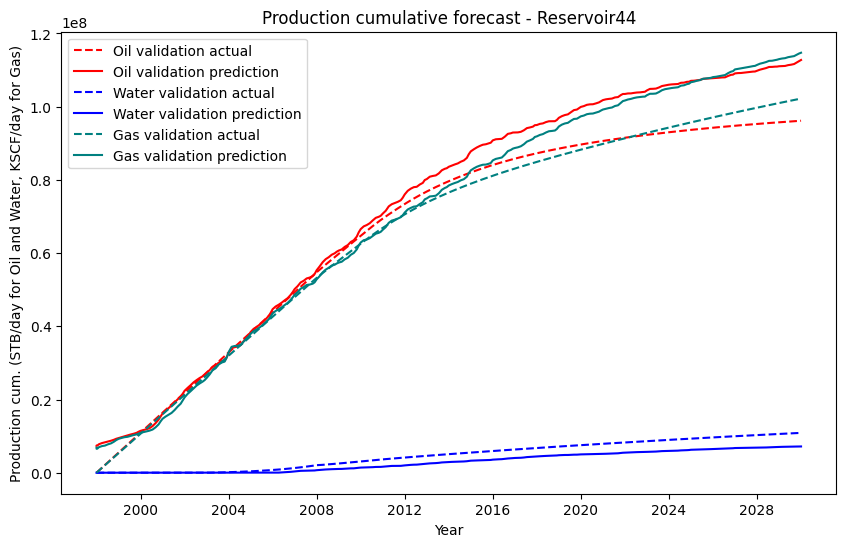

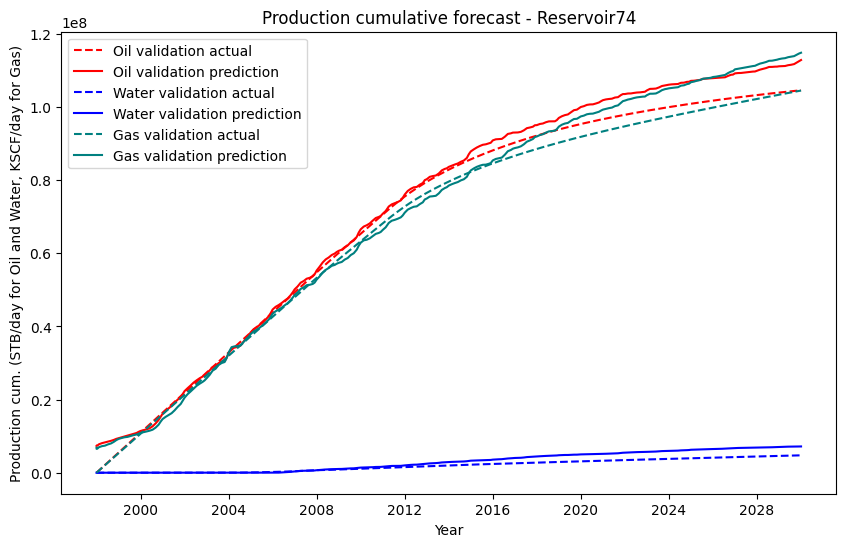

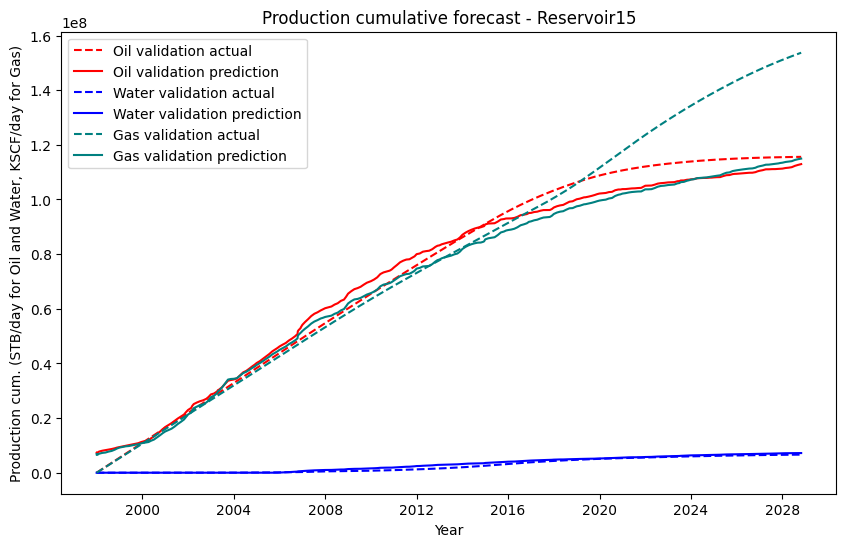

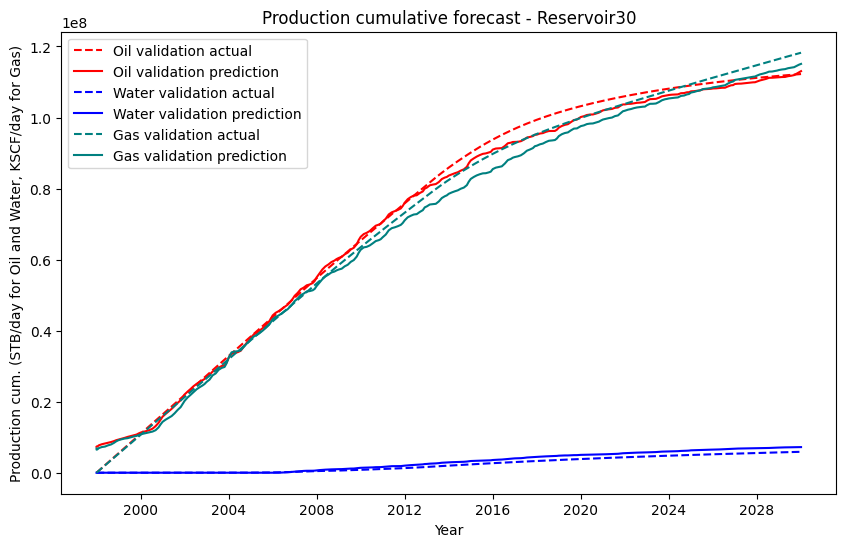

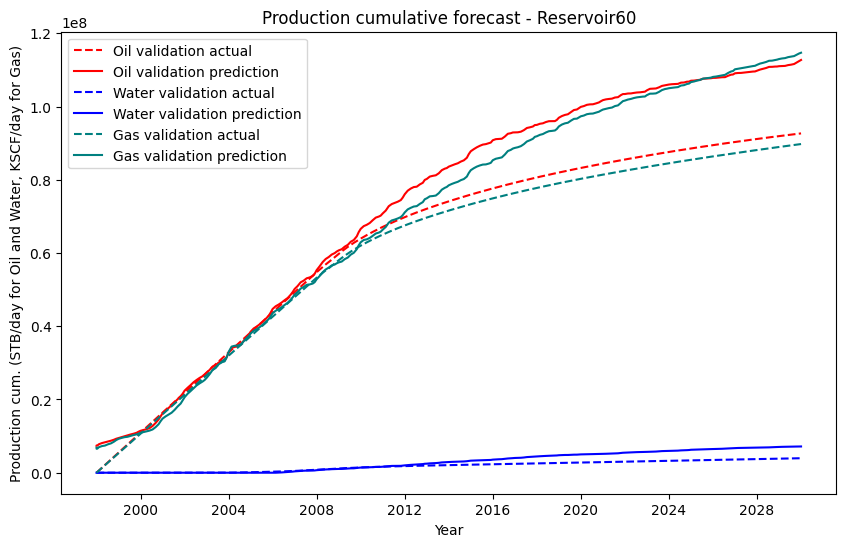

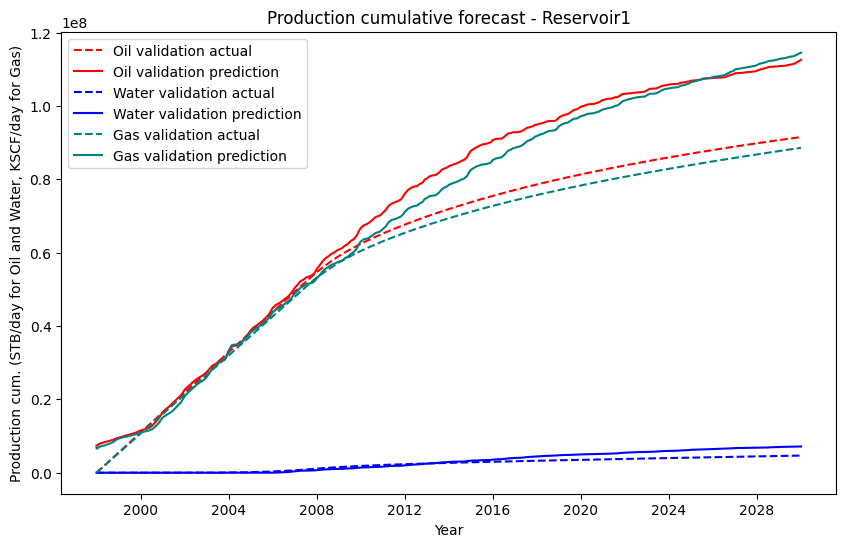

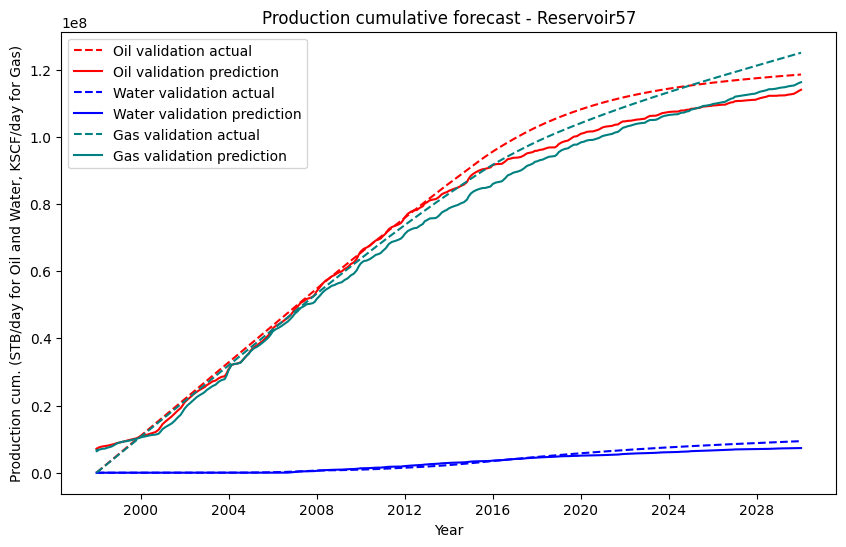

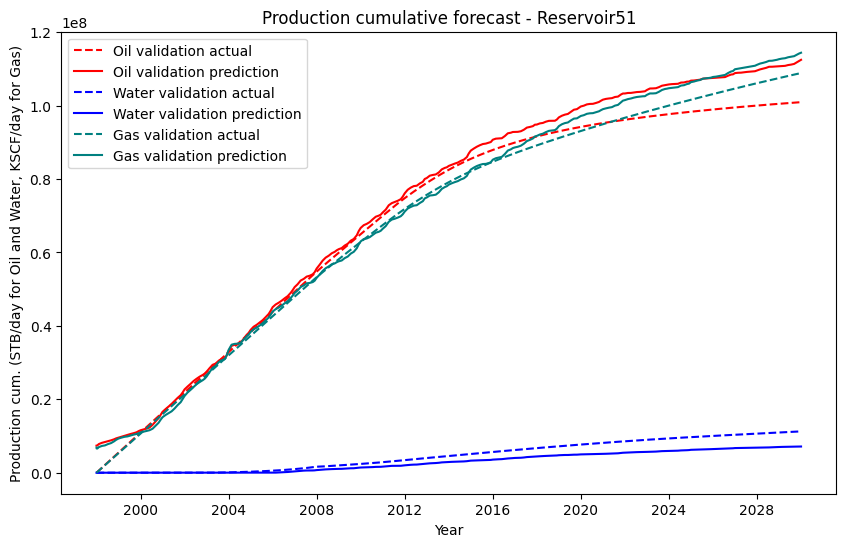

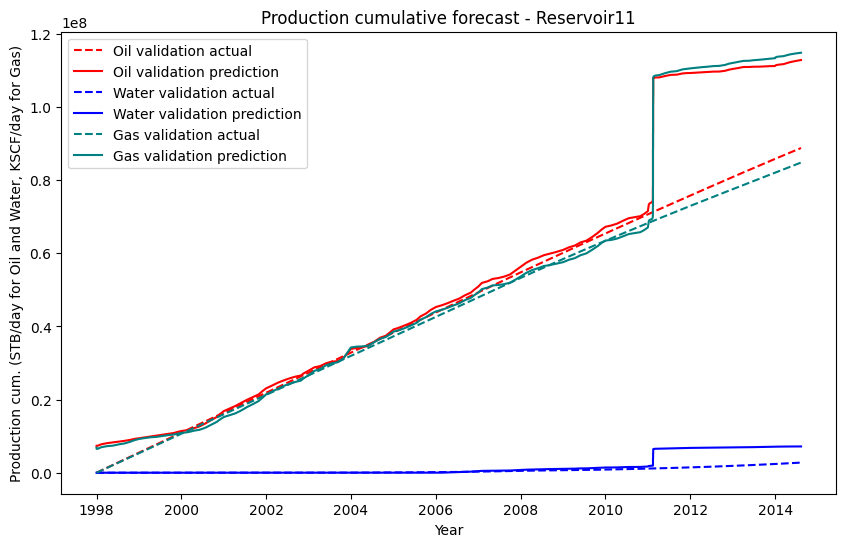

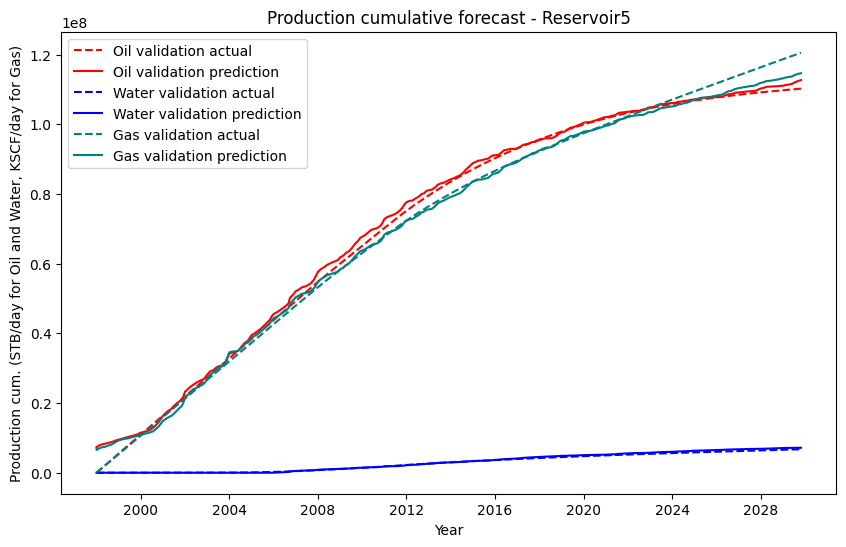

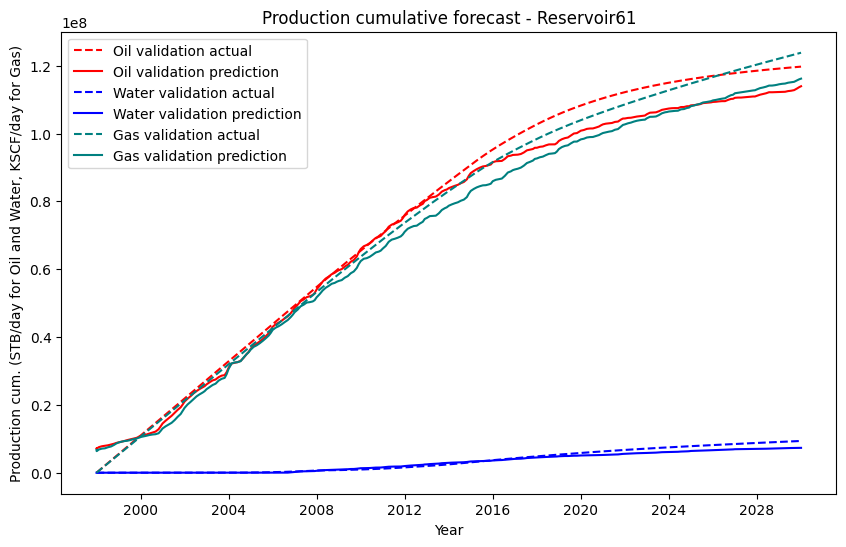

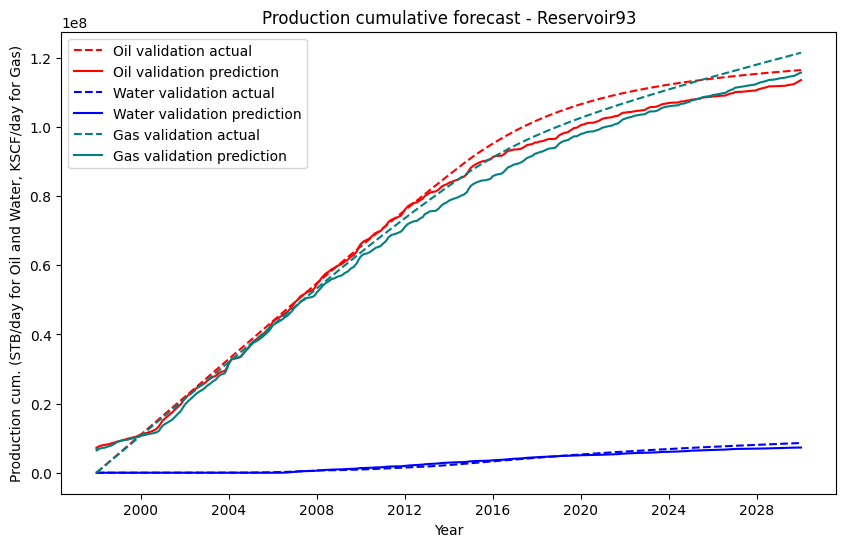

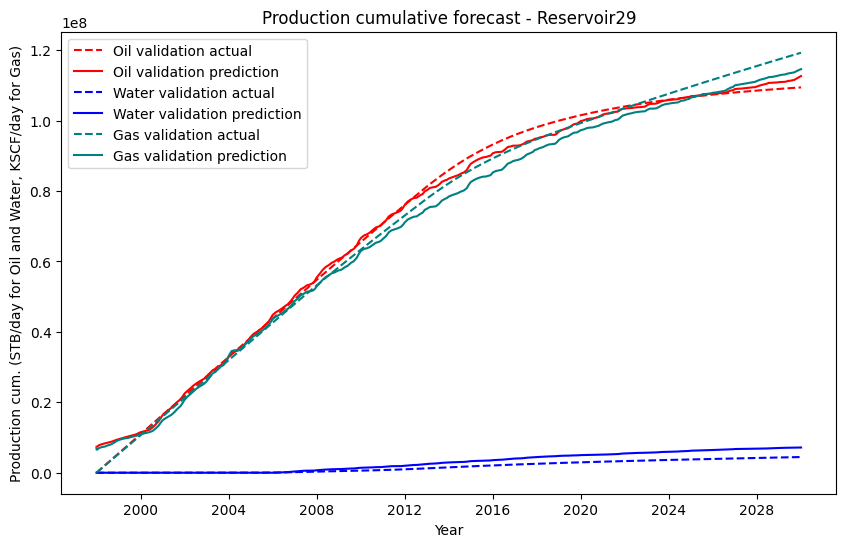

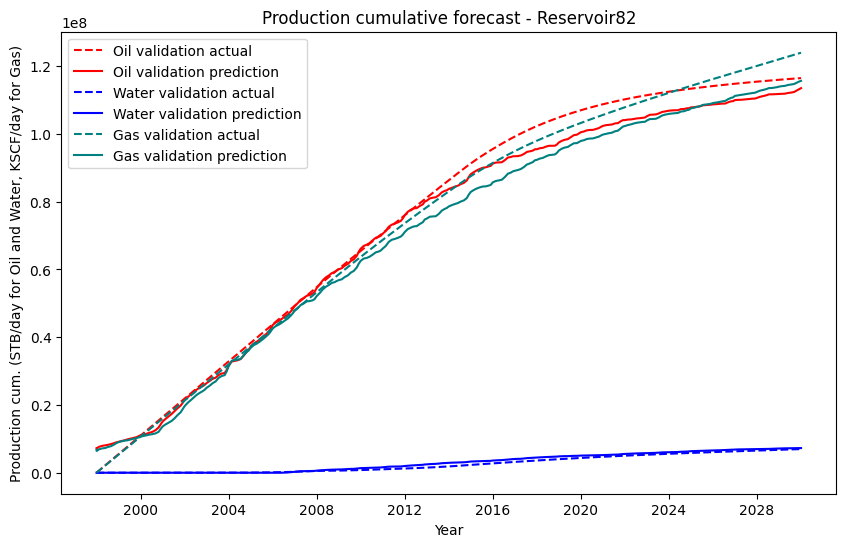

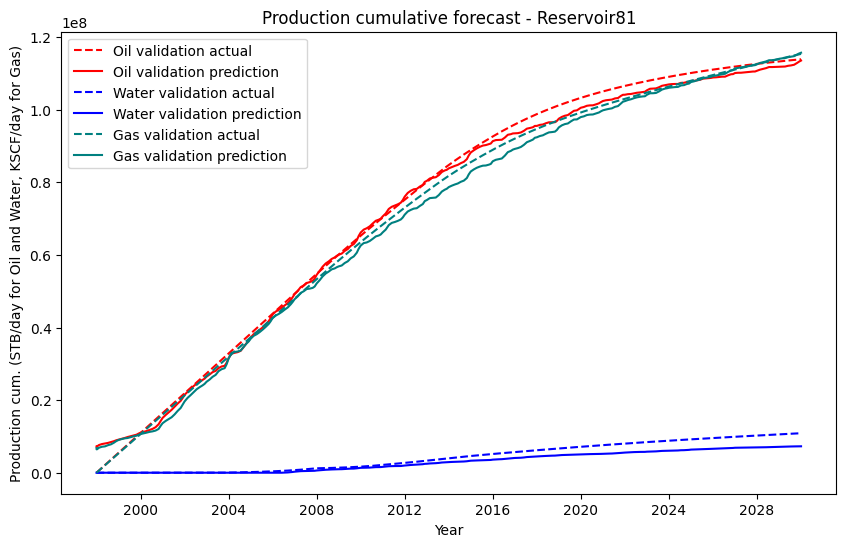

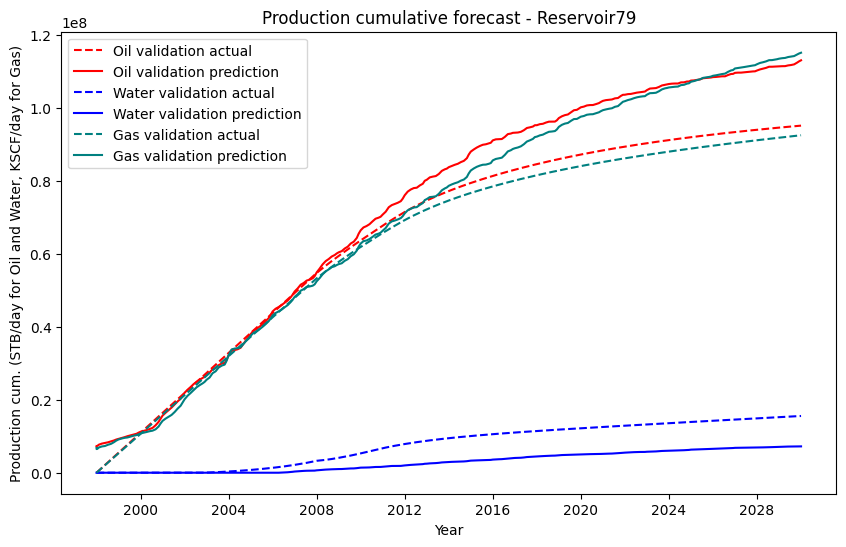

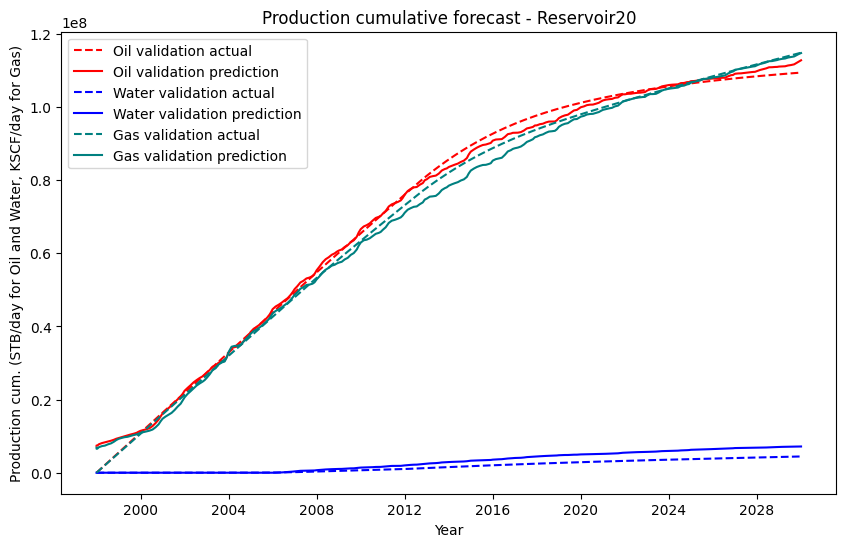

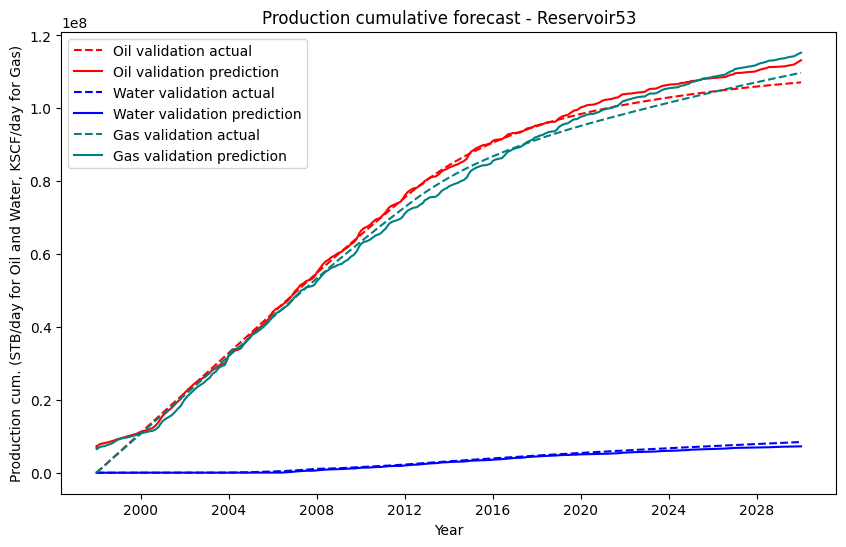

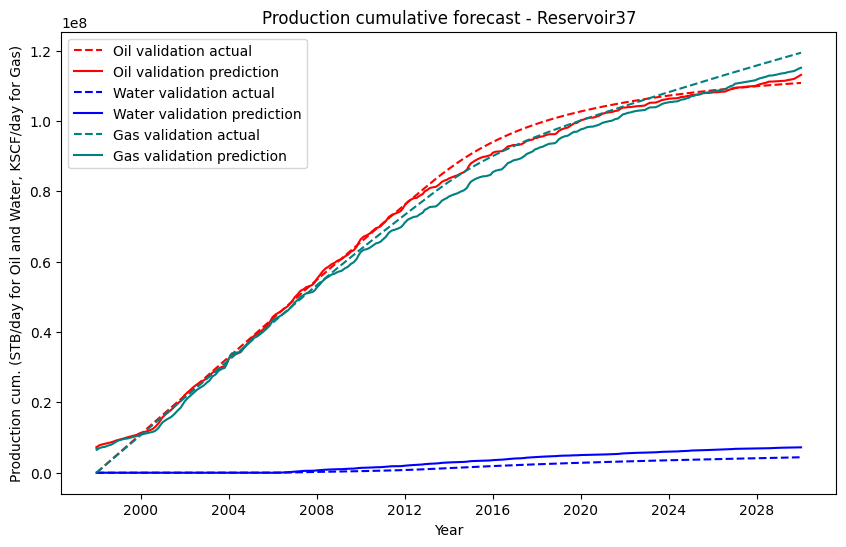

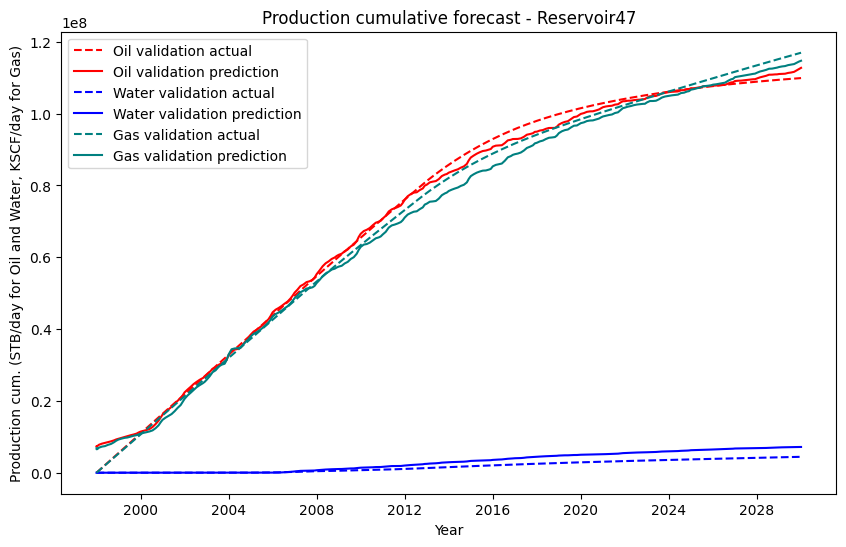

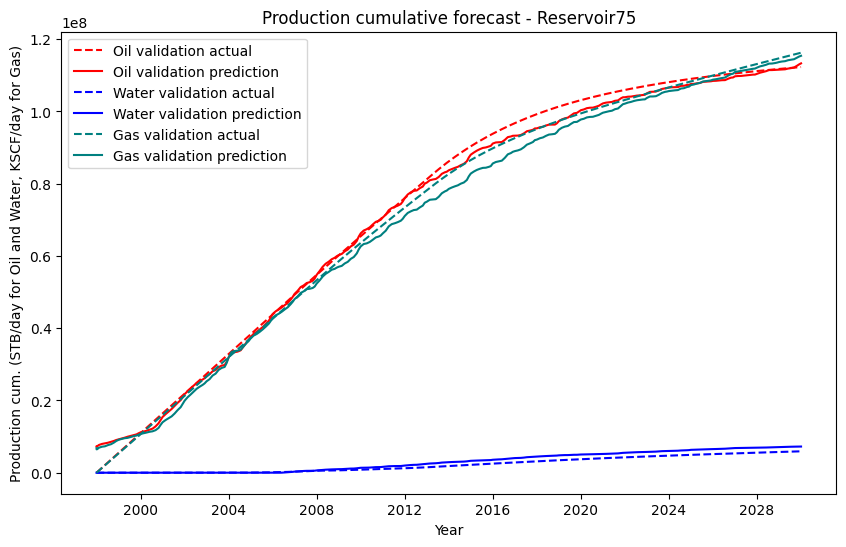

In [83]:
for i in range(26):
  plot_all_validation_res_combined(i)

Zip the combined plots

In [ ]:
!zip -r validation_plots_combined.zip '/content/validation_plots_combined'

# Inference on testing dataset

Import testing dataset, do all the pre-processing

In [85]:
testing_path = '/content/dataset/test/' # Testing path
pathlist_test = os.listdir(testing_path) # Testing path list
print(len(pathlist_test)) # There should be 10 reservoirs in testing

10


In [ ]:
display(pathlist_test)

In [86]:
dflist_testing_inputs = [pd.read_csv(testing_path + path) for path in pathlist_test]

In [87]:
df_spatial_testing = (np.vstack(dflist_testing_inputs)).reshape(10, 5183, 8) # vstack and reshape spatial testing dataset

In [88]:
normalized_X_test = train_scaler_X.fit_transform(df_spatial_testing.reshape(10*5183, 8))
normalized_X_test = normalized_X_test.copy().reshape(10, 5183, 8)

In [90]:
# Make predictions
testing_predictions = model.predict(normalized_X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


In [91]:
# Inverse transform the predictions
testing_predictions_denorm = train_scaler_Y.inverse_transform(testing_predictions.reshape(10*260, 3))
testing_predictions = testing_predictions_denorm.copy().reshape(10, 260, 3) # Reshape back to original shape

Export test reservoir predictions

In [92]:
!mkdir PNA_test_results

In [93]:
filenames = ['Reservoir16_production', 'Reservoir96_production', 'Reservoir6_production', 'Reservoir26_production', 'Reservoir76_production', 'Reservoir66_production', 'Reservoir46_production', 'Reservoir36_production', 'Reservoir86_production', 'Reservoir56_production']

for i in range(10):
  filename = '/content/PNA_test_results/' + filenames[i] + '.csv'
  df_production_test = pd.DataFrame(testing_predictions[i], columns=['Gas production cumulative', 'Oil production cumulative', 'Water production cumulative'], index=df_outputs_list[i][:260].index)
  df_production_test.to_csv(filename)

Zip the exported csv's

In [ ]:
!zip -r PNA_test_results.zip '/content/PNA_test_results'

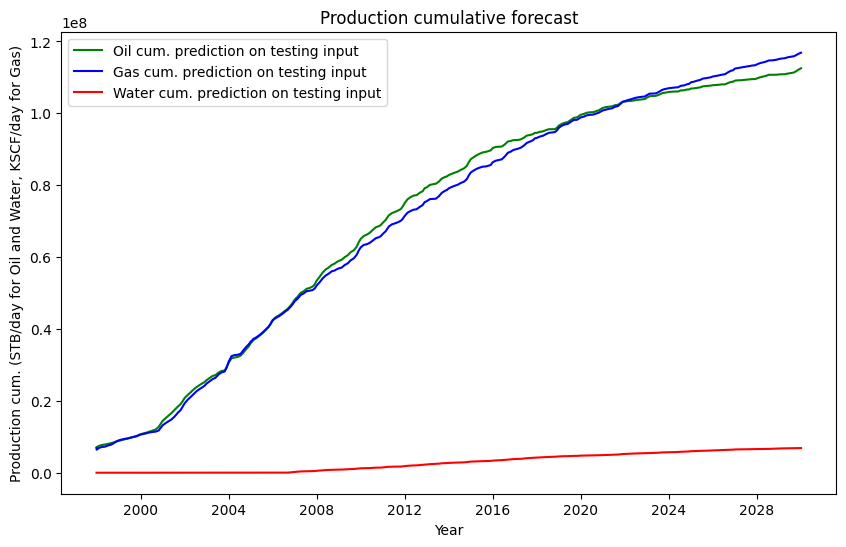

In [95]:
plt.figure(figsize=(10, 6))
test_reservoir = 2

plt.plot(df_outputs_list[test_reservoir][:260].index, testing_predictions[test_reservoir][:, 1:2], label='Oil cum. prediction on testing input',color='green')
plt.plot(df_outputs_list[test_reservoir][:260].index, testing_predictions[test_reservoir][:, 0:1], label='Gas cum. prediction on testing input',color='blue')
plt.plot(df_outputs_list[test_reservoir][:260].index, testing_predictions[test_reservoir][:, 2:3], label='Water cum. prediction on testing input',color='red')


plt.title('Production cumulative forecast')
plt.xlabel('Year')
plt.ylabel('Production cum. (STB/day for Oil and Water, KSCF/day for Gas)')
plt.legend()
plt.show()

Make a folder to store testing plots

In [96]:
!mkdir test_graphs

Function to generate testing plots

In [97]:
def plot_all_test_res(reservoir):
  plt.figure(figsize=(10, 6))

  plt.plot(df_outputs_list[reservoir][:260].index, testing_predictions[reservoir][:, 1:2], label='Oil cum. prediction on testing input',color='red')
  plt.plot(df_outputs_list[reservoir][:260].index, testing_predictions[reservoir][:, 0:1], label='Gas cum. prediction on testing input',color='teal')
  plt.plot(df_outputs_list[reservoir][:260].index, testing_predictions[reservoir][:, 2:3], label='Water cum. prediction on testing input',color='blue')


  plt.title(f'Production cumulative forecast - {pathlist_test[reservoir]}')
  plt.xlabel('Year')
  plt.ylabel('Production cum. (STB/day for Oil and Water, KSCF/day for Gas)')
  plt.legend()

  filename = '/content/test_graphs/' + pathlist_test[reservoir] + '.png'
  plt.savefig(filename, dpi=300)

  plt.show()

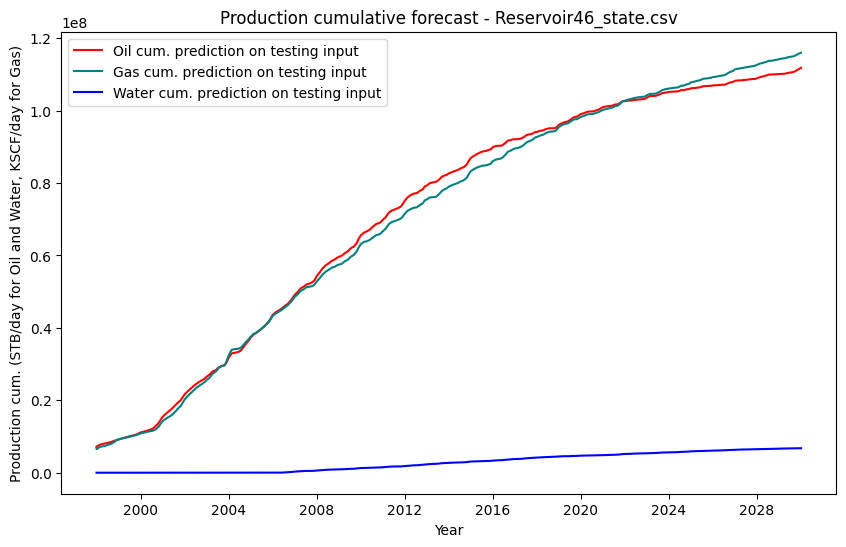

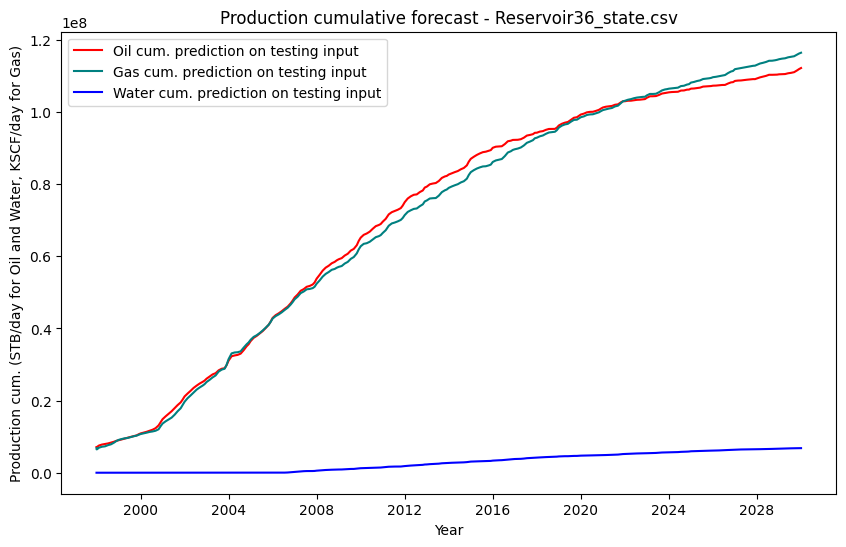

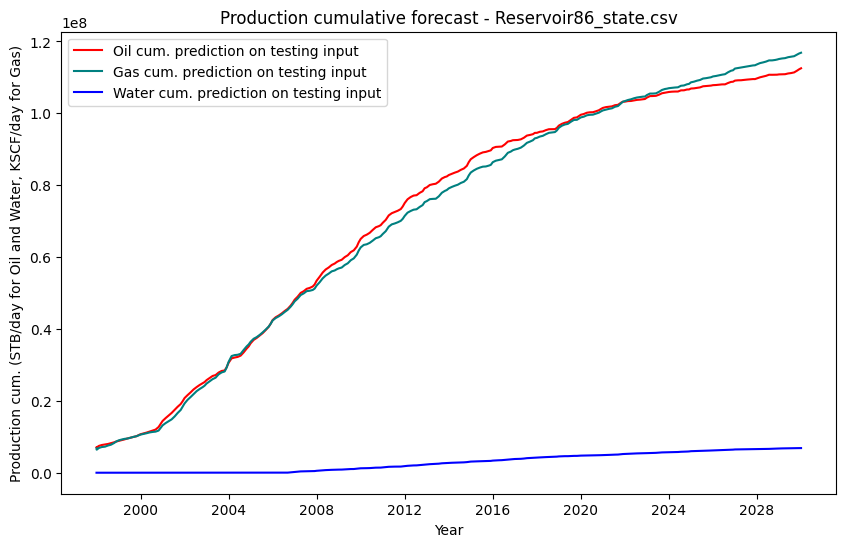

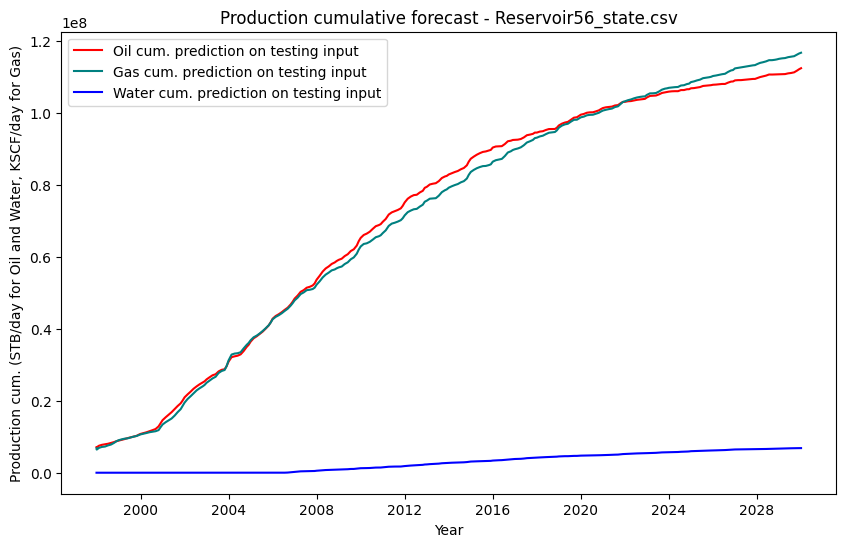

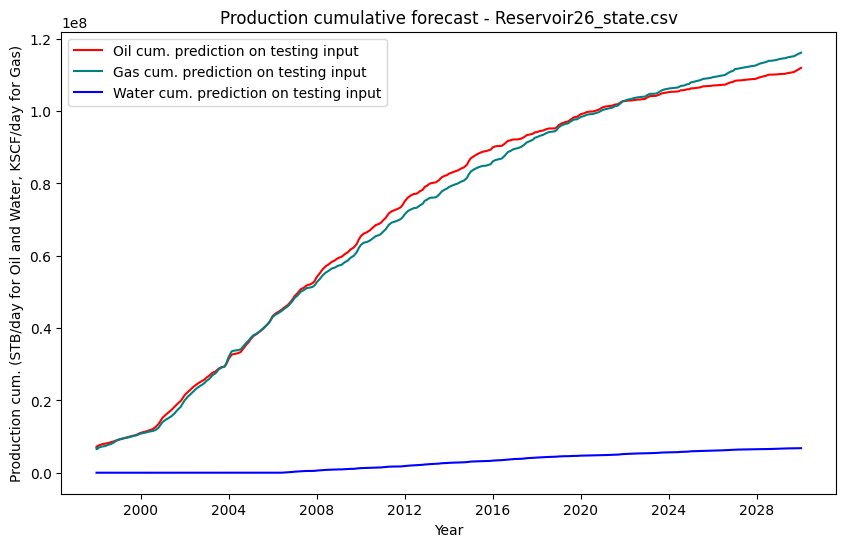

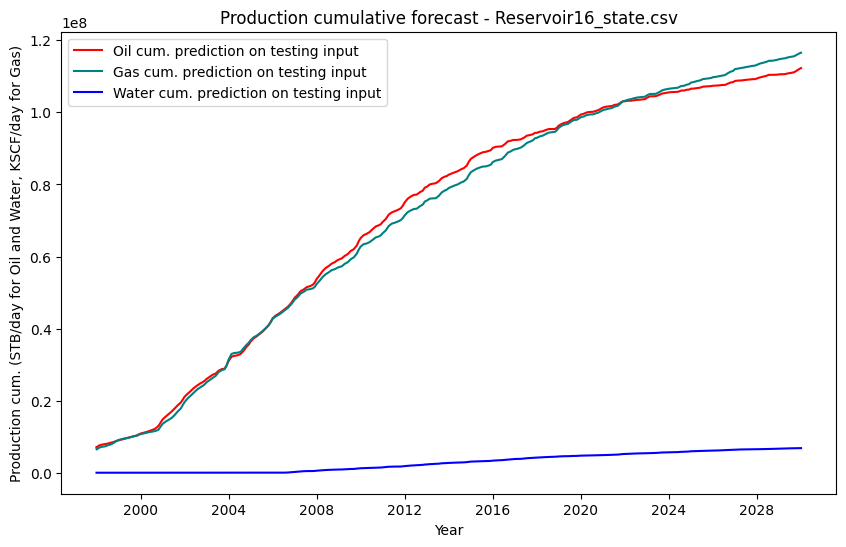

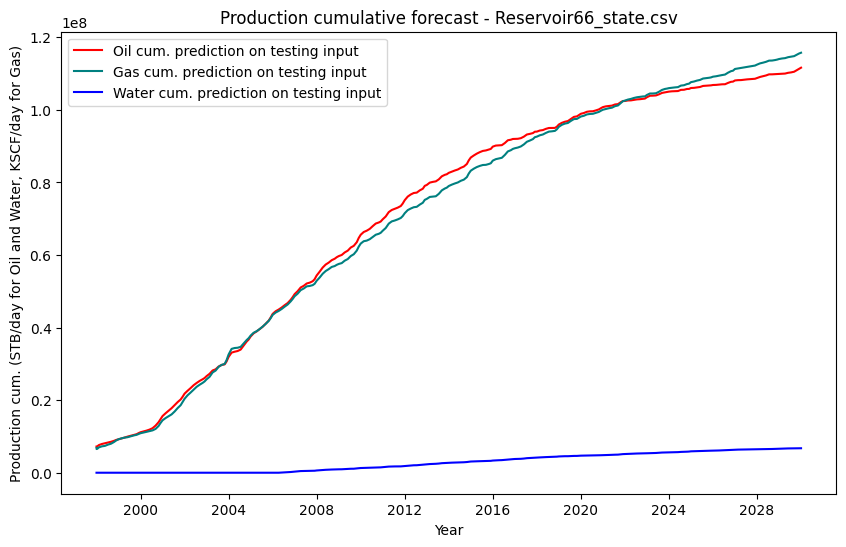

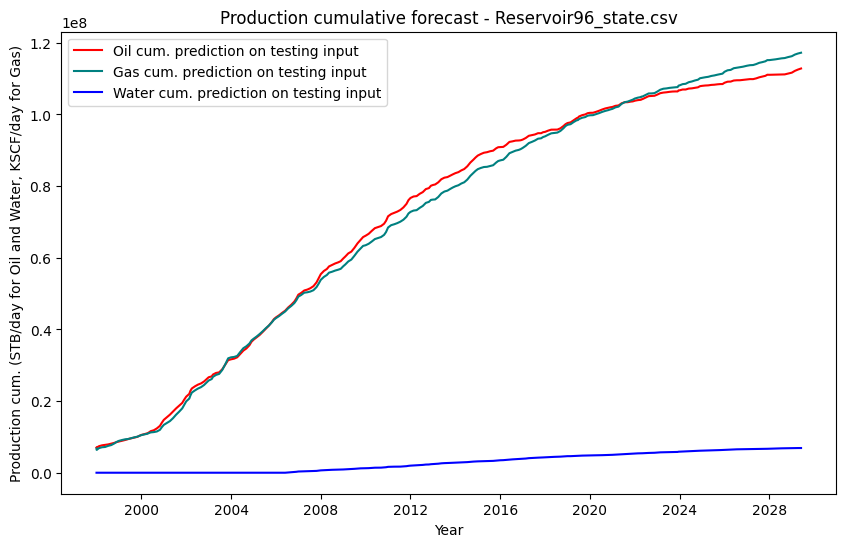

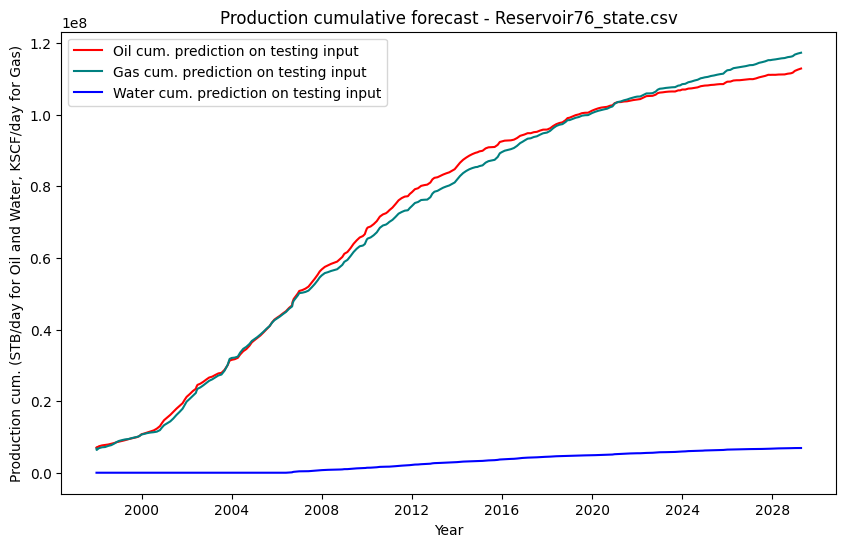

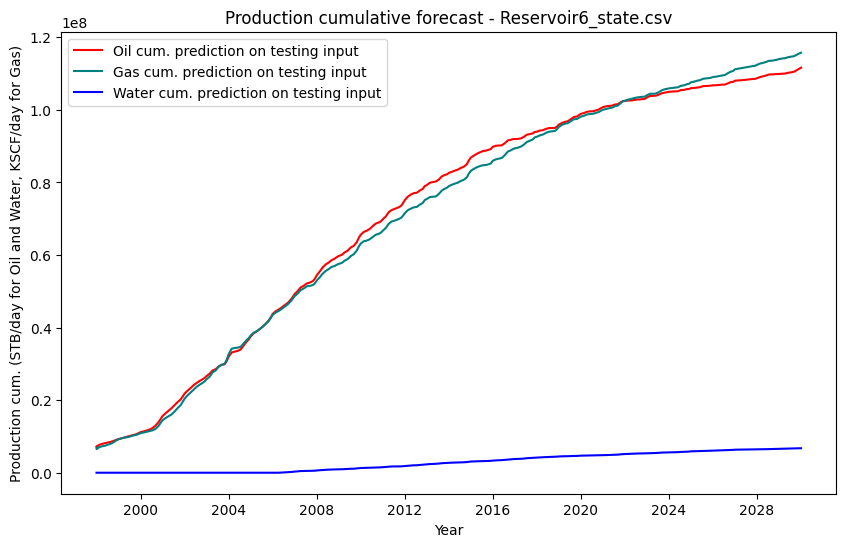

In [98]:
for i in range(10):
  plot_all_test_res(i)

Zip the testing plots

In [ ]:
!zip -r PNA_test_graphs.zip '/content/test_graphs'